# AI Investor Project Analysis:

Steps:

1. Install Yahoo! Finance API and pull JPM stock data as a test case.
2. Load data from yfinance api
3. Feature Engineering
4. Model Testing
5. Running steps 1-4 over all stocks in S&P 500
6. Analyzing Results from step 6 and risk strategy. 
7. Next Steps for Analysis

## 1. Install yfinance package

In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24095 sha256=9e089d9bfdbad08f60ab9647c464750a2553b0a5b25d88e404f2d0c20c5da315
  Stored in directory: /Users/jonathan.bocanegra/Library/Caches/pip/wheels/f9/e9/7e/8b13db3bf3aeb5049d759e10702736fb96753089ac950fddc0
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8368 sha256=c28e7994d6835e15618f801e4c162a5b792d0c6f8f81afaa1eec54096ed16e78
  Stored in directory: /Users/jonathan.bocanegra/Library/Caches/pip/wheels/57/6d/a3/a39b839cc75274d2acfb1c58bfead2f726c6577fe8c4723f13
Successfully built yfinance multitasking


## 2. Importing the Data and Using JPM as Test Case

In [2]:
import yfinance as yf

In [201]:
data = yf.download('JPM', start='2019-01-01', end = '2021-10-31')
data.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
data['market_cap'] = data['adj_close']*data['volume']

[*********************100%***********************]  1 of 1 completed
                  Open        High        Low       Close  Adj Close    Volume
Date                                                                          
2019-01-02   95.949997   99.779999  95.940002   99.309998  90.652069  15670900
2019-01-03   98.639999   98.889999  96.690002   97.110001  89.363739  16286400
2019-01-04   99.110001  100.930000  98.279999  100.690002  92.658165  16935200
2019-01-07  100.430000  101.470001  99.709999  100.760002  92.722588  15430700
2019-01-08  101.629997  101.820000  99.550003  100.570000  92.547752  13578800


## 3. Feature Engineering

1. Lagged Closing Price Variables
2. Lagged High / Low Price Variables
3. Volatility Variables

In [131]:
## Making the Lagged Closing Price Features:

## Creates the y variable, X variable, the corresponding index and the column names

def closing_price_lag(index, close_prices, period = 6, column_prefix = 't_minus'):
    X = []
    ind = []
    cols = []
    
    for i in range(len(close_prices)-period):
        X.append(close_prices[i:i+period])
        ind.append(index[i+period])
    
    for i in range(period,0,-1):
        words = [column_prefix, str(i)]
        cols.append("".join(words))
        
    return X,ind,cols

In [133]:
X,ind,cols = closing_price_lag(index = list(np.array(data.index)), close_prices = list(data['close']), period = 6)

[[99.30999755859375,
  97.11000061035156,
  100.69000244140625,
  100.76000213623047,
  100.56999969482422,
  100.4000015258789],
 [97.11000061035156,
  100.69000244140625,
  100.76000213623047,
  100.56999969482422,
  100.4000015258789,
  100.38999938964844]]

[numpy.datetime64('2019-01-10T00:00:00.000000000'),
 numpy.datetime64('2019-01-11T00:00:00.000000000')]

['t_minus6', 't_minus5', 't_minus4', 't_minus3', 't_minus2', 't_minus1']

list

In [120]:
## Making the Previous 2 days Highs and Lows

data_sub = data[['high', 'low']]

data_sub['t_minus1_high'] = data_sub['high'].shift(1)
data_sub['t_minus2_high'] = data_sub['high'].shift(2)

data_sub['t_minus1_low'] = data_sub['low'].shift(1)
data_sub['t_minus2_low'] = data_sub['low'].shift(2)

high_low_lags = data_sub[['t_minus1_high', 't_minus2_high', 't_minus1_low', 't_minus2_low']]

<ipython-input-120-01201ba0a590>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-120-01201ba0a590>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus2_high'] = data_sub['high'].shift(2)
<ipython-input-120-01201ba0a590>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [127]:
import pandas as pd
test_features = pd.DataFrame(X, index = ind, columns = cols)
full_data = test_features.merge(data, how = 'inner', left_index=True, right_index=True)
full_data = full_data.merge(high_low_lags, how = 'inner', left_index=True, right_index=True)
display(full_data.head())
display(full_data.columns)

,t_minus6,t_minus5,t_minus4,t_minus3,t_minus2,t_minus1,open,high,low,close,adj_close,volume,market_cap,t_minus1_high,t_minus2_high,t_minus1_low,t_minus2_low
2019-01-10,99.309998,97.110001,100.690002,100.760002,100.570000,100.400002,100.019997,100.730003,99.269997,100.389999,92.382103,14376100,1.328094e+09,101.489998,101.820000,99.930000,99.550003
2019-01-11,97.110001,100.690002,100.760002,100.570000,100.400002,100.389999,99.889999,100.169998,98.949997,99.910004,91.940392,15439900,1.419550e+09,100.730003,101.489998,99.269997,99.930000
2019-01-14,100.690002,100.760002,100.570000,100.400002,100.389999,99.910004,98.870003,101.360001,98.660004,100.940002,92.888222,21258500,1.974664e+09,100.169998,100.730003,98.949997,99.269997
2019-01-15,100.760002,100.570000,100.400002,100.389999,99.910004,100.940002,98.889999,102.470001,98.599998,101.680000,93.569199,26504900,2.480042e+09,101.360001,100.169998,98.660004,98.949997
2019-01-16,100.570000,100.400002,100.389999,99.910004,100.940002,101.680000,102.250000,103.449997,101.800003,102.500000,94.323799,18533000,1.748103e+09,102.470001,101.360001,98.599998,98.660004


Index(['t_minus6', 't_minus5', 't_minus4', 't_minus3', 't_minus2', 't_minus1',
       'open', 'high', 'low', 'close', 'adj_close', 'volume', 'market_cap',
       't_minus1_high', 't_minus2_high', 't_minus1_low', 't_minus2_low'],
      dtype='object')

In [128]:
full_data['prev_day_intraday_volatility'] = abs(full_data['t_minus1_high']-full_data['t_minus1_low'])/(full_data['t_minus1'])
full_data['past_six_day_volatility'] = (full_data[['t_minus6', 't_minus5', 't_minus4', 't_minus3', 't_minus2', 't_minus1']].apply(lambda x: x.max(), axis=1)-full_data[['t_minus6', 't_minus5', 't_minus4', 't_minus3', 't_minus2', 't_minus1']].apply(lambda x: x.min(), axis=1))/(full_data[['t_minus6', 't_minus5', 't_minus4', 't_minus3', 't_minus2', 't_minus1']].apply(lambda x: x.mean(), axis=1))
full_data.head()

,t_minus6,t_minus5,t_minus4,t_minus3,t_minus2,t_minus1,open,high,low,close,adj_close,volume,market_cap,t_minus1_high,t_minus2_high,t_minus1_low,t_minus2_low,prev_day_intraday_volatility,past_six_day_volatility
2019-01-10,99.309998,97.110001,100.690002,100.760002,100.570000,100.400002,100.019997,100.730003,99.269997,100.389999,92.382103,14376100,1.328094e+09,101.489998,101.820000,99.930000,99.550003,0.015538,0.036571
2019-01-11,97.110001,100.690002,100.760002,100.570000,100.400002,100.389999,99.889999,100.169998,98.949997,99.910004,91.940392,15439900,1.419550e+09,100.730003,101.489998,99.269997,99.930000,0.014543,0.036505
2019-01-14,100.690002,100.760002,100.570000,100.400002,100.389999,99.910004,98.870003,101.360001,98.660004,100.940002,92.888222,21258500,1.974664e+09,100.169998,100.730003,98.949997,99.269997,0.012211,0.008462
2019-01-15,100.760002,100.570000,100.400002,100.389999,99.910004,100.940002,98.889999,102.470001,98.599998,101.680000,93.569199,26504900,2.480042e+09,101.360001,100.169998,98.660004,98.949997,0.026749,0.010249
2019-01-16,100.570000,100.400002,100.389999,99.910004,100.940002,101.680000,102.250000,103.449997,101.800003,102.500000,94.323799,18533000,1.748103e+09,102.470001,101.360001,98.599998,98.660004,0.038061,0.017586


## 4. Model Build

The project specifies to use RandomForestRegressor but wanted to compare against LinearRegression as a baseline. I did test a number of other models, but don't have the documentation contained in this notebook. 

1. Test / Train Split
2. Test RandomForestRegressor
3. Test Linear Regression
4. Analyzing Residuals for Statistical Validity
5. Deeper Look at Linear Regression Using StatsModel

In [30]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [277]:
## Training and Testing Split
date_split = '2021-07-29'
non_x_columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'market_cap']

## Training Data is January 1, 2019 -> July 31, 2021
training_data = full_data.loc[:date_split]
testing_data = full_data.loc[date_split:]

## Training Data
y_train = training_data['close'].tolist()
X_train = training_data.drop(non_x_columns, axis=1).values.tolist()

## Testing Data
y_test = testing_data['close'].tolist()
X_test = testing_data.drop(non_x_columns, axis=1).values.tolist()

In [176]:
testing_data.head()

,t_minus6,t_minus5,t_minus4,t_minus3,t_minus2,t_minus1,open,high,low,close,adj_close,volume,market_cap,t_minus1_high,t_minus2_high,t_minus1_low,t_minus2_low,prev_day_intraday_volatility,past_six_day_volatility
2021-04-29,150.539993,147.369995,150.190002,150.559998,151.250000,152.229996,153.539993,155.279999,153.199997,155.190002,153.376602,12976900,1.990353e+09,152.889999,151.570007,151.399994,150.110001,0.009788,0.032323
2021-04-30,147.369995,150.190002,150.559998,151.250000,152.229996,155.190002,154.100006,154.490005,153.009995,153.809998,152.012726,11705100,1.779324e+09,155.279999,152.889999,153.199997,151.399994,0.013403,0.051743
2021-05-03,150.190002,150.559998,151.250000,152.229996,155.190002,153.809998,154.850006,155.479996,153.130005,153.360001,151.567993,11801100,1.788669e+09,154.490005,155.279999,153.009995,153.199997,0.009622,0.032850
2021-05-04,150.559998,151.250000,152.229996,155.190002,153.809998,153.360001,152.869995,155.639999,152.139999,155.479996,153.663208,12977700,1.994195e+09,155.479996,154.490005,153.130005,153.009995,0.015323,0.030314
2021-05-05,151.250000,152.229996,155.190002,153.809998,153.360001,155.479996,156.000000,158.279999,154.630005,157.520004,155.679367,10506700,1.635676e+09,155.639999,155.479996,152.139999,153.130005,0.022511,0.027547


### 4.2 RandomForestRegressor

In [234]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_preds = rf_reg.predict(X_train)
print('Training Data Mean Squared Error: ', mean_squared_error(y_train, y_preds))

y_preds_test = rf_reg.predict(X_test)
print('Testing Data Mean Squared Error: ', mean_squared_error(y_test, y_preds_test))

Training Data Mean Squared Error:  0.9868180787845671
Testing Data Mean Squared Error:  39.47240920131208


Major overfitting. Likely due to tree depth and min leaf splits

In [503]:
## Hyper-Parameter Tuning
rf_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [248]:
#This many parameters will take a very long time to load
param = {'bootstrap': [True],
 'ccp_alpha': [0.0, 0.05,0.1,0.15,0.20,0.25],
 'criterion': ['mse'],
 'max_depth': [5,7,8,9,10,11,12,13,14,15,20,50],
 'max_features': ['auto'],
 'max_leaf_nodes': [None],
 'max_samples': [None],
 'min_impurity_decrease': [0.0],
 'min_impurity_split': [None],
 'min_samples_leaf': [1,5,10,20,30,40],
 'min_samples_split': [2,3,4,5,6,7,8,9,10],
 'min_weight_fraction_leaf': [0.0],
 'n_estimators': [100,200],
 'n_jobs': [None],
 'oob_score': [False],
 'random_state': [None],
 'verbose': [0],
 'warm_start': [False]}

In [249]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
?RandomizedSearchCV

In [260]:
## Use a randomized Search to get general idea of where the optimal parameters are, and then use gridsearch. 

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
# define search
search = RandomizedSearchCV(rf_reg, param, scoring='neg_mean_squared_error', cv=cv, n_iter=50).fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -6.882375586166153
Best Hyperparameters: {'warm_start': False, 'verbose': 0, 'random_state': None, 'oob_score': False, 'n_jobs': None, 'n_estimators': 200, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 4, 'min_samples_leaf': 10, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'mse', 'ccp_alpha': 0.05, 'bootstrap': True}


In [263]:
rf_reg_tuned = RandomForestRegressor(**search.best_params_)
rf_reg_tuned.fit(X_train, y_train)
y_preds_tuned = rf_reg_tuned.predict(X_train)
print('Training Data Mean Squared Error Tuned: ', mean_squared_error(y_train, y_preds_tuned))

y_preds_test_tuned = rf_reg_tuned.predict(X_test)
print('Testing Data Mean Squared Error Tuned: ', mean_squared_error(y_test, y_preds_test_tuned))

Training Data Mean Squared Error Tuned:  4.34782635056673
Testing Data Mean Squared Error Tuned:  36.5987616738811


In [264]:
param2 = {'bootstrap': [True],
 'ccp_alpha': [0.4,0.05,0.06],
 'criterion': ['mse'],
 'max_depth': [9,10,11],
 'max_features': ['auto'],
 'max_leaf_nodes': [None],
 'max_samples': [None],
 'min_impurity_decrease': [0.0],
 'min_impurity_split': [None],
 'min_samples_leaf': [8,9,10,11,12],
 'min_samples_split': [3,4,5],
 'min_weight_fraction_leaf': [0.0],
 'n_estimators': [200],
 'n_jobs': [None],
 'oob_score': [False],
 'random_state': [None],
 'verbose': [0],
 'warm_start': [False]}

In [265]:
search = GridSearchCV(rf_reg, param2, scoring = 'neg_mean_squared_error', cv=cv).fit(X_train, y_train)
rf_reg_tuned = RandomForestRegressor(**search.best_params_)
rf_reg_tuned.fit(X_train, y_train)
y_preds_tuned = rf_reg_tuned.predict(X_train)
print('Training Data Mean Squared Error Tuned: ', mean_squared_error(y_train, y_preds_tuned))

y_preds_test_tuned = rf_reg_tuned.predict(X_test)
print('Testing Data Mean Squared Error Tuned: ', mean_squared_error(y_test, y_preds_test_tuned))

Training Data Mean Squared Error Tuned:  4.519220744729903
Testing Data Mean Squared Error Tuned:  37.704328477758494


Welp. Even with all the hyper-parameter tuning and such. RandomForestRegressor won't be able to compete with Linear Regression.

### 4.3 Linear Regression

In [258]:
reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)
y_preds = reg.predict(X_train)
display(r2_score(y_train, y_preds))
display(mean_squared_error(y_train, y_preds))

y_preds_test = reg.predict(X_test)
display(r2_score(y_test, y_preds_test))
display(mean_squared_error(y_test, y_preds_test))


0.983529500518821

5.453041347321897

In [259]:
y_preds_test = reg.predict(X_test)
display(r2_score(y_test, y_preds_test))
display(mean_squared_error(y_test, y_preds_test))


0.8042694201516023

5.397748787709775

In [193]:
y_preds_test[0:10]

array([154.09090103, 153.19999634, 153.7905983 , 153.57229828,
       154.14439957, 155.16419708, 154.25889755, 153.62609879,
       153.77909836, 153.88629837])

### 4.4 Analyzing Residuals

In [183]:
from matplotlib import pyplot as plt

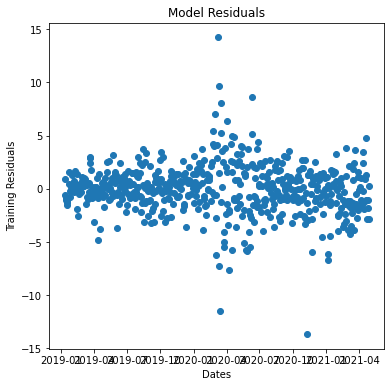

In [204]:
train_residuals = y_preds - y_train
train_residuals = pd.DataFrame(train_residuals, index = training_data.index, columns = ['train_residuals'])

plt.figure(figsize=(6,6))
plt.scatter(y = train_residuals['train_residuals'], x = train_residuals.index)
plt.xlabel('Dates')
plt.ylabel('Training Residuals')
plt.title('Model Residuals')
plt.show()

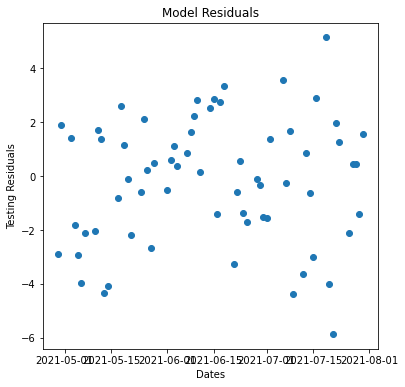

In [203]:
test_residuals = y_preds_test - y_test
test_residuals = pd.DataFrame(test_residuals, index = testing_data.index, columns = ['test_residuals'])

plt.figure(figsize=(6,6))
plt.scatter(y = test_residuals['test_residuals'], x = test_residuals.index)
plt.xlabel('Dates')
plt.ylabel('Testing Residuals')
plt.title('Model Residuals')
plt.show()

In [287]:
## Check for multi-colinearity
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = training_data.drop(non_x_columns, axis=1)
vif = pd.DataFrame()
vif['feature'] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i)
                          for i in range(len(vif_data.columns))]

print(vif)

                         feature            VIF
0                       t_minus6    2612.691390
1                       t_minus5    4322.982070
2                       t_minus4    4490.474485
3                       t_minus3    6913.639682
4                       t_minus2   25525.182271
5                       t_minus1   22035.114078
6                  t_minus1_high  106656.513032
7                  t_minus2_high   23605.356074
8                   t_minus1_low  100620.371232
9                   t_minus2_low   24664.638787
10  prev_day_intraday_volatility      49.081416
11       past_six_day_volatility       7.134683


Stupidily high multi-colinearity

### 4.5 Deeper Look into Linear Regression Using StatsModel

In [295]:
import statsmodels.api as sm

In [298]:
drop_cols = ['open', 'high', 'low', 'adj_close', 'volume', 'market_cap', 
             'past_six_day_volatility', 't_minus2_high', 't_minus2_low']

ols_training = training_data.drop(drop_cols, axis=1)

ols = sm.OLS(ols_training['close'], sm.add_constant(ols_training.drop(['close'], axis=1))).fit()
ols.summary()

## Let's drop past_six_day_volatility, t_minus2_high, t_minus2_low
## Still high multi-colinearity. But let's check out what the LinearRegression in SkLearn spits out

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     5684.
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:10:24   Log-Likelihood:                -1465.3
No. Observations:                 643   AIC:                             2951.
Df Residuals:                     633   BIC:                             2995.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.3747      0.979     -1.404      0.161      -3.297       0.548
t_minus6                        -0.0977      0.039     -2.477      0.014      -0.175      -0.020
t_minus5                         0.2076      0.051      4.065      0.000       0.107       0.308
t_minus4                        -0.0752      0.052     -1.444      0.149      -0.177       0.027
t_minus3                        -0.1449      0.052     -2.785      0.006      -0.247      -0.043
t_minus2                         0.1479      0.064      2.305      0.022       0.022       0.274
t_minus1                         0.6648      0.115      5.788      0.000       0.439       0.890
t_minus1_high                   -0.9840      0.368     -2.673      0.008      -1.707      -0.261
t_minus1_low                     1.2980      0.376      3.456      0.001       0.560       2.036
prev_day_intraday_volatility   105.8171     37.120      2.851      0.005      32.924     178.710
==============================================================================
Omnibus:                       90.856   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              978.620
Skew:                           0.078   Prob(JB):                    3.13e-213
Kurtosis:                       9.042   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Linear Regression FTW!
Linear Regression provides the best r_squared and the best RMSE for the testing datasets.

In [301]:
## Training and Testing Split
date_split = '2021-04-29'
non_x_columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'market_cap', 
                 'past_six_day_volatility', 't_minus2_high', 't_minus2_low']

## Training Data is January 1, 2019 -> July 31, 2021
training_data = full_data.loc[:date_split]
testing_data = full_data.loc[date_split:]

## Training Data
y_train = training_data['close'].tolist()
X_train = training_data.drop(non_x_columns, axis=1).values.tolist()

## Testing Data
y_test = testing_data['close'].tolist()
X_test = testing_data.drop(non_x_columns, axis=1).values.tolist()

reg = LinearRegression()
reg.fit(X_train, y_train)
y_preds = reg.predict(X_train)
print('---- Training Data Metrics ----')
display(r2_score(y_train, y_preds))
display(mean_squared_error(y_train, y_preds))

y_preds_test = reg.predict(X_test)
print('---- Testing Data Metrics ----')
display(r2_score(y_test, y_preds_test))
display(mean_squared_error(y_test, y_preds_test))


---- Training Data Metrics ----


0.982957052934146

5.642566889760612

---- Testing Data Metrics ----


0.8128571151253943

5.1609221243957935

Well hey. I'll take it!!

## 5. Run Process Through All S&P 500 Stocks

Requirements:
1. Stocks need to have data from Jan 2019 - Present. 
2. Have data for October 2021

In [451]:
## constituents.csv on Github

ticker_data = pd.read_csv('constituents.csv')
display(ticker_data.head())
display(ticker_data.shape)

ticker_to_remove = ['IVZ', 'CARR', 'CTVA', 'DOW', 'FOX', 'FOXA', 'OGN', 'OTIS']
ticker_data = ticker_data[~ticker_data['Symbol'].isin(ticker_to_remove)]

tickers = ticker_data['Symbol']
display(ticker_data.shape)

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care


(503, 3)

(495, 3)

In [ ]:
#### Analysis of the ticker data
np.random.seed(1234)

all_stock_data = pd.DataFrame([])

for ticker in tickers:
    data = yf.download(ticker, start='2019-01-01', end = '2021-11-04')
    data['ticker'] = ticker
    all_stock_data = all_stock_data.append(data)

a = pd.DataFrame(all_stock_data.groupby('ticker')['date'].min()).reset_index()
a[a['date']>'2019-01-02'][['ticker']]

In [452]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics

np.random.seed(1234)
period = 6
date_split = '2021-04-29'
build_end_date = '2021-09-30'

## User Inputs
today = input("What is today's date: valid through 2021-10-10?")
tomorrow = input("What is tomorrow's date: valid through 2021-10-11")
nbr = input("How many stocks do you want to see?")
strategy = input("What is your strategy? (aggresive, conservative, moderate)")

## Import The Ticker Reference Data
ticker_data = pd.read_csv('constituents.csv')
ticker_to_remove = ['IVZ', 'CARR', 'CTVA', 'DOW', 'FOX', 'FOXA', 'OGN', 'OTIS']
ticker_data = ticker_data[~ticker_data['Symbol'].isin(ticker_to_remove)]
tickers = ticker_data['Symbol']

## Build the model for each ticker
#### Empty Lists to fill for the For Loop
ticker_validations_train = []
model_validations_train = []
metric_validations_train = []

ticker_validations_test = []
model_validations_test = []
metric_validations_test = []

ticker_predictions = []
model_predictions = []
date_predictions = []
todays_close = []

ticker_std = []
close_std = []

#### The Almight For Loop
for ticker in tickers:
    
    print('Analyzing', ticker)
    ## Importing Data
    data = yf.download(ticker, start='2019-01-01', end = '2021-10-15')
    data.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
    data = data[~data['close'].isnull()]
    
    ## Feature Engineering
    
    #### 1) Lagged Closing Prices
    X,ind,cols = closing_price_lag(index = list(np.array(data.index)), close_prices = list(data['close']), period = period)
    
    #### 2) Lagged High / Low Prices
    data_sub = data[['high', 'low']]
    data_sub['t_minus1_high'] = data_sub['high'].shift(1)
    data_sub['t_minus1_low'] = data_sub['low'].shift(1)
    high_low_lags = data_sub[['t_minus1_high', 't_minus1_low']]

    #### 3) Putting Steps 1 & 2 Together
    test_features = pd.DataFrame(X, index = ind, columns = cols)
    full_data = test_features.merge(data, how = 'inner', left_index=True, right_index=True)
    full_data = full_data.merge(high_low_lags, how = 'inner', left_index=True, right_index=True)

    #### 4) Previous Day - Intraday Volatility
    full_data['prev_day_intraday_volatility'] = abs(full_data['t_minus1_high']-full_data['t_minus1_low'])/(full_data['t_minus1'])

    ## Modeling Building
    
    #### 1) Training / Testing Data Split
    ####### Columns to Remove
    non_x_columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

    ####### Training Data is January 1, 2019 -> July 31, 2021
    training_data = full_data.loc[:date_split]
    testing_data = full_data.loc[date_split:]

    ####### Training Data
    y_train = training_data['close'].tolist()
    X_train = training_data.drop(non_x_columns, axis=1).values.tolist()

    ####### Testing Data
    y_test = testing_data['close'].tolist()
    X_test = testing_data.drop(non_x_columns, axis=1).values.tolist()

    #### 2) Build The Linear Regression
    reg = LinearRegression(normalize=True)
    reg.fit(X_train, y_train)

    #### 3) Model Validation
    
    ####### Training Data Validations
    y_preds = reg.predict(X_train)

    ticker_validations_train.append(ticker)
    model_validations_train.append(r2_score(y_train, y_preds))
    metric_validations_train.append('r2_score')

    ticker_validations_train.append(ticker)
    model_validations_train.append(mean_squared_error(y_train, y_preds))
    metric_validations_train.append('mse')

    ####### Testing Data Validations
    y_preds_test = reg.predict(X_test)
    
    ticker_validations_test.append(ticker)
    model_validations_test.append(r2_score(y_test, y_preds_test))
    metric_validations_test.append('r2_score')
    
    ticker_validations_test.append(ticker)
    model_validations_test.append(mean_squared_error(y_test, y_preds_test))
    metric_validations_test.append('mse')  
    
    print(ticker, 'testing r2_score:', r2_score(y_test, y_preds_test))
    print(ticker, 'testing MSE score:', mean_squared_error(y_test, y_preds_test))
    
    ## Final Model Build
    training_data = full_data.loc[:build_end_date]
    y_train = training_data['close'].tolist()
    X_train = training_data.drop(non_x_columns, axis=1).values.tolist()
    
    reg = LinearRegression(normalize=True).fit(X_train, y_train)
    
    todays_data = [full_data.loc[today].drop(non_x_columns).tolist()]
    
    tomorrow_pred = reg.predict(todays_data)
    
    print(ticker, ": tomorrow's price:", tomorrow_pred)
    ticker_predictions.append(ticker)
    model_predictions.append(tomorrow_pred)
    date_predictions.append(tomorrow)
    
    ## Conservative vs. Aggressive Strategy (6month STD)
    close_std.append(data['close'].loc['2021-05-01':'2021-10-29'].std())
    ticker_std.append(ticker)
    
    todays_close.append(full_data.loc[today].close)
    print(ticker, 'Success!')
    print(" ")
    print(" ")


## Turn the created Lists into DataFrames
train_validations = {
    'ticker' : ticker_validations_train,
    'validation_score' : model_validations_train,
    'validation_metric': metric_validations_train
}

train_validations = pd.DataFrame(train_validations, index=None)

test_validations = {
    'ticker' : ticker_validations_test,
    'validation_score' : model_validations_test,
    'validation_metric': metric_validations_test
}

test_validations = pd.DataFrame(test_validations, index=None)

model_predictions = {
    'ticker' : ticker_predictions,
    'prediction': np.concatenate(model_predictions).ravel(),
    'todays_close': todays_close
}

model_prediction = pd.DataFrame(model_predictions, index=None)

std = {
    'ticker' : ticker_std,
    'std_close' : close_std
}

std_close = pd.DataFrame(std, index=None)

## Calculate Expected Percent Change
model_prediction['perc_change'] = (model_prediction['prediction'] / model_prediction['todays_close']) - 1

## Join all the tables together
all_model_data = model_prediction.merge(std_close, how = 'left', on = 'ticker')
all_model_data = all_model_data.merge(ticker_data, how = 'left', left_on = 'ticker', right_on = 'Symbol')

## Create the Strategy Column
conditions = [
    all_model_data['std_close'] < 2.5,
    all_model_data['std_close'] < 8,
    all_model_data['std_close'] >= 8
    ]

values = ['conservative', 'moderate', 'aggressive']

all_model_data['strategy'] = np.select(conditions, values)

## Create the view and print the data
columns_to_display = ['Name', 'ticker','perc_change', 'todays_close', 'prediction']
all_model_data[(all_model_data['strategy']==strategy) & (all_model_data['perc_change']>0)][columns_to_display].sort_values('perc_change', ascending =False).head(n=nbr)

Analyzing MMM
[*********************100%***********************]  1 of 1 completed
MMM testing r2_score: 0.9467873309307206
MMM testing MSE score: 4.087690467646773
MMM : tomorrow's price: [176.56306079]
MMM Success!
 
 
Analyzing AOS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AOS testing r2_score: 0.8832470617407225
AOS testing MSE score: 0.9929550699202724
AOS : tomorrow's price: [61.55081954]
AOS Success!
 
 
Analyzing ABT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ABT testing r2_score: 0.9239049522184535
ABT testing MSE score: 2.262700807798485
ABT : tomorrow's price: [117.49771293]
ABT Success!
 
 
Analyzing ABBV


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ABBV testing r2_score: 0.8739216530740445
ABBV testing MSE score: 1.8197672593404173
ABBV : tomorrow's price: [108.90851499]
ABBV Success!
 
 
Analyzing ABMD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ABMD testing r2_score: 0.9436679577734967
ABMD testing MSE score: 40.7265158071369
ABMD : tomorrow's price: [323.12641343]
ABMD Success!
 
 
Analyzing ACN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ACN testing r2_score: 0.9762965514806116
ACN testing MSE score: 10.499958762895547
ACN : tomorrow's price: [323.91082283]
ACN Success!
 
 
Analyzing ATVI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ATVI testing r2_score: 0.9621298156021053
ATVI testing MSE score: 2.1540510335945946
ATVI : tomorrow's price: [78.27955798]
ATVI Success!
 
 
Analyzing ADM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ADM testing r2_score: 0.9420640373817811
ADM testing MSE score: 0.5745592900535792
ADM : tomorrow's price: [60.68888162]
ADM Success!
 
 
Analyzing ADBE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ADBE testing r2_score: 0.9772590727368069
ADBE testing MSE score: 80.9498330640248
ADBE : tomorrow's price: [576.8461874]
ADBE Success!
 
 
Analyzing AAP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AAP testing r2_score: 0.8313753510608851
AAP testing MSE score: 8.205950602952795
AAP : tomorrow's price: [206.85530157]
AAP Success!
 
 
Analyzing AMD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AMD testing r2_score: 0.966992503269036
AMD testing MSE score: 5.252825782233105
AMD : tomorrow's price: [102.72308]
AMD Success!
 
 
Analyzing AES


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AES testing r2_score: 0.8655111462042979
AES testing MSE score: 0.14374383179686917
AES : tomorrow's price: [22.86295214]
AES Success!
 
 
Analyzing AFL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AFL testing r2_score: 0.811698862881628
AFL testing MSE score: 0.4760669674984365
AFL : tomorrow's price: [52.6813904]
AFL Success!
 
 
Analyzing A


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
A testing r2_score: 0.9841947566479259
A testing MSE score: 3.2410957185857097
A : tomorrow's price: [155.34825779]
A Success!
 
 
Analyzing APD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
APD testing r2_score: 0.9483237706453949
APD testing MSE score: 10.35077849138605
APD : tomorrow's price: [256.881928]
APD Success!
 
 
Analyzing AKAM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AKAM testing r2_score: 0.9050494615818099
AKAM testing MSE score: 1.9595742852031863
AKAM : tomorrow's price: [105.63169114]
AKAM Success!
 
 
Analyzing ALK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ALK testing r2_score: 0.9297864225349046
ALK testing MSE score: 1.5350937850776512
ALK : tomorrow's price: [61.9454932]
ALK Success!
 
 
Analyzing ALB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ALB testing r2_score: 0.9722587988753205
ALB testing MSE score: 24.52135911972427
ALB : tomorrow's price: [220.18583372]
ALB Success!
 
 
Analyzing ARE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ARE testing r2_score: 0.9550376914600208
ARE testing MSE score: 5.020809339618559
ARE : tomorrow's price: [192.72602912]
ARE Success!
 
 
Analyzing ALGN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ALGN testing r2_score: 0.9404798388726527
ALGN testing MSE score: 162.63583673660133
ALGN : tomorrow's price: [665.02330412]
ALGN Success!
 
 
Analyzing ALLE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ALLE testing r2_score: 0.7074331381416571
ALLE testing MSE score: 3.522080943986928
ALLE : tomorrow's price: [132.12336894]
ALLE Success!
 
 
Analyzing LNT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LNT testing r2_score: 0.8620764775424646
LNT testing MSE score: 0.46548723099593453
LNT : tomorrow's price: [55.62829846]
LNT Success!
 
 
Analyzing ALL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ALL testing r2_score: 0.7389304477295688
ALL testing MSE score: 3.086983173281826
ALL : tomorrow's price: [127.37490771]
ALL Success!
 
 
Analyzing GOOGL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GOOGL testing r2_score: 0.9732666895473645
GOOGL testing MSE score: 1087.5538243026713
GOOGL : tomorrow's price: [2731.99236165]
GOOGL Success!
 
 
Analyzing GOOG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GOOG testing r2_score: 0.969236944956208
GOOG testing MSE score: 1038.706394428807
GOOG : tomorrow's price: [2729.47172939]
GOOG Success!
 
 
Analyzing MO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MO testing r2_score: 0.7925087193533743
MO testing MSE score: 0.35649262054044073
MO : tomorrow's price: [45.85999049]
MO Success!
 
 
Analyzing AMZN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AMZN testing r2_score: 0.879954588628922
AMZN testing MSE score: 2585.3151429427066
AMZN : tomorrow's price: [3284.97932511]
AMZN Success!
 
 
Analyzing AMCR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AMCR testing r2_score: 0.8682164828146348
AMCR testing MSE score: 0.021247381335285025
AMCR : tomorrow's price: [11.67661951]
AMCR Success!
 
 
Analyzing AEE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AEE testing r2_score: 0.857515116071419
AEE testing MSE score: 0.8039550911720779
AEE : tomorrow's price: [80.45053848]
AEE Success!
 
 
Analyzing AAL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AAL testing r2_score: 0.8776204101841358
AAL testing MSE score: 0.2847350441372778
AAL : tomorrow's price: [21.84708873]
AAL Success!
 
 
Analyzing AEP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AEP testing r2_score: 0.8806608351694517
AEP testing MSE score: 0.8031591078301272
AEP : tomorrow's price: [81.30965449]
AEP Success!
 
 
Analyzing AXP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AXP testing r2_score: 0.8113420051625111
AXP testing MSE score: 7.0297125680654515
AXP : tomorrow's price: [172.30960574]
AXP Success!
 
 
Analyzing AIG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AIG testing r2_score: 0.9234481929922727
AIG testing MSE score: 0.8674089789288851
AIG : tomorrow's price: [55.45037333]
AIG Success!
 
 
Analyzing AMT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AMT testing r2_score: 0.9646401960985447
AMT testing MSE score: 8.396430835490824
AMT : tomorrow's price: [265.41500144]
AMT Success!
 
 
Analyzing AWK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AWK testing r2_score: 0.9638138785062096
AWK testing MSE score: 4.451467425646987
AWK : tomorrow's price: [168.34287092]
AWK Success!
 
 
Analyzing AMP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AMP testing r2_score: 0.8368788437118908
AMP testing MSE score: 17.514419424951253
AMP : tomorrow's price: [267.81157083]
AMP Success!
 
 
Analyzing ABC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ABC testing r2_score: 0.7307282271515387
ABC testing MSE score: 2.7057643871649577
ABC : tomorrow's price: [119.67489799]
ABC Success!
 
 
Analyzing AME


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AME testing r2_score: 0.8514007545995531
AME testing MSE score: 2.159071130389526
AME : tomorrow's price: [124.68334702]
AME Success!
 
 
Analyzing AMGN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AMGN testing r2_score: 0.9607008840092341
AMGN testing MSE score: 7.497358448801342
AMGN : tomorrow's price: [213.53283746]
AMGN Success!
 
 
Analyzing APH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
APH testing r2_score: 0.9565352578136551
APH testing MSE score: 0.608368357362744
APH : tomorrow's price: [74.48402575]
APH Success!
 
 
Analyzing ADI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ADI testing r2_score: 0.8340926615685054
ADI testing MSE score: 6.8467878820202195
ADI : tomorrow's price: [167.12779497]
ADI Success!
 
 
Analyzing ANSS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ANSS testing r2_score: 0.8584350203116954
ANSS testing MSE score: 32.33195745561405
ANSS : tomorrow's price: [343.99971073]
ANSS Success!
 
 
Analyzing ANTM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ANTM testing r2_score: 0.602854987790556
ANTM testing MSE score: 31.739583115105766
ANTM : tomorrow's price: [371.1688796]
ANTM Success!
 
 
Analyzing AON


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AON testing r2_score: 0.9684738103913957
AON testing MSE score: 15.675993976212133
AON : tomorrow's price: [289.23550151]
AON Success!
 
 
Analyzing APA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
APA testing r2_score: 0.8744516239298801
APA testing MSE score: 0.5051314409151361
APA : tomorrow's price: [21.899075]
APA Success!
 
 
Analyzing AAPL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AAPL testing r2_score: 0.9621835502225874
AAPL testing MSE score: 3.3619969988954503
AAPL : tomorrow's price: [142.05066955]
AAPL Success!
 
 
Analyzing AMAT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AMAT testing r2_score: 0.695035638496132
AMAT testing MSE score: 9.355180574424121
AMAT : tomorrow's price: [129.46124645]
AMAT Success!
 
 
Analyzing APTV


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
APTV testing r2_score: 0.848480260995008
APTV testing MSE score: 9.787828472680685
APTV : tomorrow's price: [152.50730271]
APTV Success!
 
 
Analyzing ANET


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ANET testing r2_score: 0.9147911783736979
ANET testing MSE score: 28.755409507553438
ANET : tomorrow's price: [348.57643238]
ANET Success!
 
 
Analyzing AJG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AJG testing r2_score: 0.877655886829845
AJG testing MSE score: 2.915121856861947
AJG : tomorrow's price: [151.61995898]
AJG Success!
 
 
Analyzing AIZ


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AIZ testing r2_score: 0.8267706637120107
AIZ testing MSE score: 3.6066095557698192
AIZ : tomorrow's price: [158.40480847]
AIZ Success!
 
 
Analyzing T


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
T testing r2_score: 0.9481289053852215
T testing MSE score: 0.1183686334727867
T : tomorrow's price: [27.15855847]
T Success!
 
 
Analyzing ATO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ATO testing r2_score: 0.9336759133445454
ATO testing MSE score: 1.2749445357538378
ATO : tomorrow's price: [88.81741638]
ATO Success!
 
 
Analyzing ADSK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ADSK testing r2_score: 0.9167618319732076
ADSK testing MSE score: 29.373929963684937
ADSK : tomorrow's price: [284.2491963]
ADSK Success!
 
 
Analyzing ADP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ADP testing r2_score: 0.889722138209319
ADP testing MSE score: 4.861512733342342
ADP : tomorrow's price: [200.4576446]
ADP Success!
 
 
Analyzing AZO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AZO testing r2_score: 0.9547910954424161
AZO testing MSE score: 408.4494101703743
AZO : tomorrow's price: [1664.93396058]
AZO Success!
 
 
Analyzing AVB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AVB testing r2_score: 0.9485767086375065
AVB testing MSE score: 6.795737348241538
AVB : tomorrow's price: [220.30242475]
AVB Success!
 
 
Analyzing AVY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AVY testing r2_score: 0.8433024878382984
AVY testing MSE score: 6.429373781674334
AVY : tomorrow's price: [209.92669393]
AVY Success!
 
 
Analyzing BKR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BKR testing r2_score: 0.9026506173436674
BKR testing MSE score: 0.3265093839164393
BKR : tomorrow's price: [25.13286737]
BKR Success!
 
 
Analyzing BLL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BLL testing r2_score: 0.953632787413001
BLL testing MSE score: 1.3313841498337335
BLL : tomorrow's price: [89.8881823]
BLL Success!
 
 
Analyzing BAC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BAC testing r2_score: 0.8383329944242603
BAC testing MSE score: 0.4612513853498442
BAC : tomorrow's price: [42.95932301]
BAC Success!
 
 
Analyzing BBWI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BBWI testing r2_score: 0.917894347060878
BBWI testing MSE score: 2.1465818969638613
BBWI : tomorrow's price: [64.24661225]
BBWI Success!
 
 
Analyzing BAX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BAX testing r2_score: 0.9120320260725419
BAX testing MSE score: 0.9187326206523505
BAX : tomorrow's price: [81.18622721]
BAX Success!
 
 
Analyzing BDX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BDX testing r2_score: 0.8292579642522072
BDX testing MSE score: 7.24219783460658
BDX : tomorrow's price: [244.39497926]
BDX Success!
 
 
Analyzing BBY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BBY testing r2_score: 0.7363497755358165
BBY testing MSE score: 4.622033577496343
BBY : tomorrow's price: [105.31743711]
BBY Success!
 
 
Analyzing BIO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BIO testing r2_score: 0.9856728368420702
BIO testing MSE score: 91.36195846052453
BIO : tomorrow's price: [741.46147583]
BIO Success!
 
 
Analyzing TECH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TECH testing r2_score: 0.9555895016933218
TECH testing MSE score: 61.112244367105205
TECH : tomorrow's price: [495.35709253]
TECH Success!
 
 
Analyzing BIIB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BIIB testing r2_score: 0.8957069173111213
BIIB testing MSE score: 153.7334097462785
BIIB : tomorrow's price: [282.85234459]
BIIB Success!
 
 
Analyzing BLK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BLK testing r2_score: 0.8431464307872141
BLK testing MSE score: 151.15834714671593
BLK : tomorrow's price: [842.71401014]
BLK Success!
 
 
Analyzing BK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BK testing r2_score: 0.8378167623468408
BK testing MSE score: 0.6091228075444587
BK : tomorrow's price: [52.70543354]
BK Success!
 
 
Analyzing BA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BA testing r2_score: 0.8589331923208431
BA testing MSE score: 19.270896194862765
BA : tomorrow's price: [225.47543437]
BA Success!
 
 
Analyzing BKNG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BKNG testing r2_score: 0.8733882958202766
BKNG testing MSE score: 1389.7868379318738
BKNG : tomorrow's price: [2448.31964942]
BKNG Success!
 
 
Analyzing BWA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BWA testing r2_score: 0.9292175562750057
BWA testing MSE score: 0.8148050034347794
BWA : tomorrow's price: [43.80522526]
BWA Success!
 
 
Analyzing BXP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BXP testing r2_score: 0.7942778446139273
BXP testing MSE score: 3.4957593825931745
BXP : tomorrow's price: [110.98600256]
BXP Success!
 
 
Analyzing BSX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BSX testing r2_score: 0.7383341430895931
BSX testing MSE score: 0.34875975986874086
BSX : tomorrow's price: [43.61035202]
BSX Success!
 
 
Analyzing BMY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BMY testing r2_score: 0.9480882039236445
BMY testing MSE score: 0.5072310317220102
BMY : tomorrow's price: [59.25070868]
BMY Success!
 
 
Analyzing AVGO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
AVGO testing r2_score: 0.8806384314709258
AVGO testing MSE score: 38.11969880855655
AVGO : tomorrow's price: [485.65803527]
AVGO Success!
 
 
Analyzing BR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BR testing r2_score: 0.8968693301389458
BR testing MSE score: 2.9931703475472875
BR : tomorrow's price: [165.85793944]
BR Success!
 
 
Analyzing BRO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BRO testing r2_score: 0.9406764664547332
BRO testing MSE score: 0.4074684357905512
BRO : tomorrow's price: [56.69494349]
BRO Success!
 
 
Analyzing CHRW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CHRW testing r2_score: 0.9052853151903016
CHRW testing MSE score: 1.4296846773951997
CHRW : tomorrow's price: [86.30025115]
CHRW Success!
 
 
Analyzing CDNS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CDNS testing r2_score: 0.9798700470948442
CDNS testing MSE score: 3.999656748826661
CDNS : tomorrow's price: [152.97842056]
CDNS Success!
 
 
Analyzing CZR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CZR testing r2_score: 0.905700615491917
CZR testing MSE score: 7.279179552737582
CZR : tomorrow's price: [120.07907767]
CZR Success!
 
 
Analyzing CPB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CPB testing r2_score: 0.9565625938146429
CPB testing MSE score: 0.30487651567558127
CPB : tomorrow's price: [41.32447201]
CPB Success!
 
 
Analyzing COF


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
COF testing r2_score: 0.7550104507566925
COF testing MSE score: 9.4615071173297
COF : tomorrow's price: [166.35080038]
COF Success!
 
 
Analyzing CAH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CAH testing r2_score: 0.89868644236178
CAH testing MSE score: 1.2521965849655121
CAH : tomorrow's price: [49.84466262]
CAH Success!
 
 
Analyzing KMX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KMX testing r2_score: 0.8777270389029486
KMX testing MSE score: 8.419569080705608
KMX : tomorrow's price: [126.07541794]
KMX Success!
 
 
Analyzing CCL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CCL testing r2_score: 0.9260716082232503
CCL testing MSE score: 0.5412265903426053
CCL : tomorrow's price: [26.25548033]
CCL Success!
 
 
Analyzing CTLT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CTLT testing r2_score: 0.9771575022502873
CTLT testing MSE score: 3.536054077095322
CTLT : tomorrow's price: [132.87608067]
CTLT Success!
 
 
Analyzing CAT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CAT testing r2_score: 0.9514864000746214
CAT testing MSE score: 11.41622590172231
CAT : tomorrow's price: [194.17947635]
CAT Success!
 
 
Analyzing CBOE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CBOE testing r2_score: 0.8855910958181753
CBOE testing MSE score: 4.23378428834658
CBOE : tomorrow's price: [123.06797218]
CBOE Success!
 
 
Analyzing CBRE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CBRE testing r2_score: 0.9371144213979921
CBRE testing MSE score: 1.7406562779928527
CBRE : tomorrow's price: [100.39703535]
CBRE Success!
 
 
Analyzing CDW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CDW testing r2_score: 0.957766977870351
CDW testing MSE score: 5.666641393630674
CDW : tomorrow's price: [185.15470778]
CDW Success!
 
 
Analyzing CE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CE testing r2_score: 0.8555958452173289
CE testing MSE score: 5.554650417500141
CE : tomorrow's price: [153.23327973]
CE Success!
 
 
Analyzing CNC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CNC testing r2_score: 0.931863927494463
CNC testing MSE score: 1.405843050723572
CNC : tomorrow's price: [62.79208149]
CNC Success!
 
 
Analyzing CNP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CNP testing r2_score: 0.7510826185981038
CNP testing MSE score: 0.1170181709182779
CNP : tomorrow's price: [24.93896404]
CNP Success!
 
 
Analyzing CDAY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CDAY testing r2_score: 0.971918016485425
CDAY testing MSE score: 3.057641141058997
CDAY : tomorrow's price: [114.72427658]
CDAY Success!
 
 
Analyzing CERN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CERN testing r2_score: 0.9418118094440661
CERN testing MSE score: 0.5302908986553783
CERN : tomorrow's price: [70.49259059]
CERN Success!
 
 
Analyzing CF


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CF testing r2_score: 0.9324970830048421
CF testing MSE score: 1.3994604392759222
CF : tomorrow's price: [61.3499378]
CF Success!
 
 
Analyzing CRL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CRL testing r2_score: 0.9790031323310734
CRL testing MSE score: 34.730469733400156
CRL : tomorrow's price: [414.62736348]
CRL Success!
 
 
Analyzing SCHW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SCHW testing r2_score: 0.7150698934346114
SCHW testing MSE score: 1.8508340730028687
SCHW : tomorrow's price: [74.29480328]
SCHW Success!
 
 
Analyzing CHTR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CHTR testing r2_score: 0.9480150639335592
CHTR testing MSE score: 90.72802979090542
CHTR : tomorrow's price: [736.62724151]
CHTR Success!
 
 
Analyzing CVX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CVX testing r2_score: 0.848313678118575
CVX testing MSE score: 2.816134228836986
CVX : tomorrow's price: [103.70589188]
CVX Success!
 
 
Analyzing CMG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CMG testing r2_score: 0.986558463349147
CMG testing MSE score: 706.1334738838783
CMG : tomorrow's price: [1830.94785604]
CMG Success!
 
 
Analyzing CB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CB testing r2_score: 0.906546970104456
CB testing MSE score: 6.244866779632021
CB : tomorrow's price: [175.10193418]
CB Success!
 
 
Analyzing CHD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CHD testing r2_score: 0.8111818052834576
CHD testing MSE score: 0.6102277115076044
CHD : tomorrow's price: [82.04240076]
CHD Success!
 
 
Analyzing CI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CI testing r2_score: 0.9687461401759242
CI testing MSE score: 13.626738332856364
CI : tomorrow's price: [202.17160208]
CI Success!
 
 
Analyzing CINF


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CINF testing r2_score: 0.6145357750745579
CINF testing MSE score: 3.155586877094506
CINF : tomorrow's price: [114.55861258]
CINF Success!
 
 
Analyzing CTAS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CTAS testing r2_score: 0.9377446668031657
CTAS testing MSE score: 23.182173918797695
CTAS : tomorrow's price: [385.15007575]
CTAS Success!
 
 
Analyzing CSCO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CSCO testing r2_score: 0.9158924145350708
CSCO testing MSE score: 0.39392043782349007
CSCO : tomorrow's price: [54.81117249]
CSCO Success!
 
 
Analyzing C


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
C testing r2_score: 0.9033234928846554
C testing MSE score: 1.1834316253806838
C : tomorrow's price: [70.89408251]
C Success!
 
 
Analyzing CFG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CFG testing r2_score: 0.879477135155189
CFG testing MSE score: 0.8140553382172225
CFG : tomorrow's price: [48.10061779]
CFG Success!
 
 
Analyzing CTXS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CTXS testing r2_score: 0.8880378118603565
CTXS testing MSE score: 6.204457376079672
CTXS : tomorrow's price: [108.69974179]
CTXS Success!
 
 
Analyzing CLX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CLX testing r2_score: 0.887190626916839
CLX testing MSE score: 6.366945857997329
CLX : tomorrow's price: [164.4161561]
CLX Success!
 
 
Analyzing CME


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CME testing r2_score: 0.9099753930524097
CME testing MSE score: 6.969793855995176
CME : tomorrow's price: [195.24274583]
CME Success!
 
 
Analyzing CMS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CMS testing r2_score: 0.8621005990695639
CMS testing MSE score: 0.4739295944955207
CMS : tomorrow's price: [59.7275147]
CMS Success!
 
 
Analyzing KO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KO testing r2_score: 0.8819211029983359
KO testing MSE score: 0.16998572497168274
KO : tomorrow's price: [53.00624818]
KO Success!
 
 
Analyzing CTSH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CTSH testing r2_score: 0.906142842181182
CTSH testing MSE score: 1.157419062644413
CTSH : tomorrow's price: [74.86526516]
CTSH Success!
 
 
Analyzing CL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CL testing r2_score: 0.9362441974490658
CL testing MSE score: 0.5451206138922641
CL : tomorrow's price: [75.3548247]
CL Success!
 
 
Analyzing CMCSA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CMCSA testing r2_score: 0.7336676406174278
CMCSA testing MSE score: 0.7724421018952258
CMCSA : tomorrow's price: [56.98234739]
CMCSA Success!
 
 
Analyzing CMA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CMA testing r2_score: 0.9021202946383916
CMA testing MSE score: 2.1409922155815515
CMA : tomorrow's price: [82.43533888]
CMA Success!
 
 
Analyzing CAG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CAG testing r2_score: 0.9603200692134383
CAG testing MSE score: 0.15196357654749346
CAG : tomorrow's price: [33.67430573]
CAG Success!
 
 
Analyzing COP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
COP testing r2_score: 0.9379356955150504
COP testing MSE score: 1.6781599436028192
COP : tomorrow's price: [70.05490788]
COP Success!
 
 
Analyzing ED


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ED testing r2_score: 0.826977057733212
ED testing MSE score: 0.6922211712316183
ED : tomorrow's price: [71.59845098]
ED Success!
 
 
Analyzing STZ


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
STZ testing r2_score: 0.9490504316745056
STZ testing MSE score: 5.116186289103485
STZ : tomorrow's price: [213.54307423]
STZ Success!
 
 
Analyzing CPRT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CPRT testing r2_score: 0.9513459537629503
CPRT testing MSE score: 3.7562745102985704
CPRT : tomorrow's price: [139.81753105]
CPRT Success!
 
 
Analyzing GLW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GLW testing r2_score: 0.9422443257439874
GLW testing MSE score: 0.3134671076988602
GLW : tomorrow's price: [36.94174252]
GLW Success!
 
 
Analyzing COST


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
COST testing r2_score: 0.9809601224373552
COST testing MSE score: 19.496851944231835
COST : tomorrow's price: [448.95120488]
COST Success!
 
 
Analyzing CTRA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CTRA testing r2_score: 0.948855863499871
CTRA testing MSE score: 0.2049454325429864
CTRA : tomorrow's price: [22.12572145]
CTRA Success!
 
 
Analyzing CCI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CCI testing r2_score: 0.9407761964892286
CCI testing MSE score: 4.349687891731646
CCI : tomorrow's price: [172.80664451]
CCI Success!
 
 
Analyzing CSX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CSX testing r2_score: 0.8564991669855464
CSX testing MSE score: 0.18428980868679093
CSX : tomorrow's price: [30.20237279]
CSX Success!
 
 
Analyzing CMI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CMI testing r2_score: 0.92149125694283
CMI testing MSE score: 11.063469657500512
CMI : tomorrow's price: [227.90046974]
CMI Success!
 
 
Analyzing CVS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CVS testing r2_score: 0.7799985884479331
CVS testing MSE score: 1.1262168381944435
CVS : tomorrow's price: [83.61557373]
CVS Success!
 
 
Analyzing DHI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DHI testing r2_score: 0.8609648002253294
DHI testing MSE score: 3.156643284670947
DHI : tomorrow's price: [83.77013876]
DHI Success!
 
 
Analyzing DHR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DHR testing r2_score: 0.9846145198554505
DHR testing MSE score: 13.142190679981407
DHR : tomorrow's price: [302.13883716]
DHR Success!
 
 
Analyzing DRI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DRI testing r2_score: 0.822968084187027
DRI testing MSE score: 7.425740888263639
DRI : tomorrow's price: [155.64039808]
DRI Success!
 
 
Analyzing DVA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DVA testing r2_score: 0.8692416080551986
DVA testing MSE score: 3.8661895994737328
DVA : tomorrow's price: [116.62719383]
DVA Success!
 
 
Analyzing DE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DE testing r2_score: 0.8524802355322454
DE testing MSE score: 37.719023372274094
DE : tomorrow's price: [341.91927668]
DE Success!
 
 
Analyzing DAL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DAL testing r2_score: 0.8888573728168984
DAL testing MSE score: 0.8090020634728726
DAL : tomorrow's price: [45.42454343]
DAL Success!
 
 
Analyzing XRAY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
XRAY testing r2_score: 0.9162997045602409
XRAY testing MSE score: 0.8924806833642683
XRAY : tomorrow's price: [59.10688177]
XRAY Success!
 
 
Analyzing DVN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DVN testing r2_score: 0.9386601967426981
DVN testing MSE score: 0.91632071515272
DVN : tomorrow's price: [36.89026471]
DVN Success!
 
 
Analyzing DXCM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DXCM testing r2_score: 0.9815279506845274
DXCM testing MSE score: 100.89595961071863
DXCM : tomorrow's price: [548.65782526]
DXCM Success!
 
 
Analyzing FANG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FANG testing r2_score: 0.9240870629081068
FANG testing MSE score: 6.946914325579876
FANG : tomorrow's price: [98.97658408]
FANG Success!
 
 
Analyzing DLR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DLR testing r2_score: 0.8774533810377466
DLR testing MSE score: 4.055810592545678
DLR : tomorrow's price: [145.09792798]
DLR Success!
 
 
Analyzing DFS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DFS testing r2_score: 0.797718913451597
DFS testing MSE score: 5.760409712399511
DFS : tomorrow's price: [127.03508052]
DFS Success!
 
 
Analyzing DISCA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DISCA testing r2_score: 0.9585156303109809
DISCA testing MSE score: 0.4002820489773082
DISCA : tomorrow's price: [25.88254006]
DISCA Success!
 
 
Analyzing DISCK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DISCK testing r2_score: 0.9243820622225336
DISCK testing MSE score: 0.3504104200909
DISCK : tomorrow's price: [24.881702]
DISCK Success!
 
 
Analyzing DISH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DISH testing r2_score: 0.7297482361635661
DISH testing MSE score: 0.8082343418832869
DISH : tomorrow's price: [44.89737367]
DISH Success!
 
 
Analyzing DG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DG testing r2_score: 0.9506322343124765
DG testing MSE score: 5.265535864053517
DG : tomorrow's price: [209.17379106]
DG Success!
 
 
Analyzing DLTR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DLTR testing r2_score: 0.8954826796339043
DLTR testing MSE score: 5.300089271526789
DLTR : tomorrow's price: [96.53065907]
DLTR Success!
 
 
Analyzing D


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
D testing r2_score: 0.8091260956295947
D testing MSE score: 0.6755791434805171
D : tomorrow's price: [72.52376147]
D Success!
 
 
Analyzing DPZ


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DPZ testing r2_score: 0.9499936878020425
DPZ testing MSE score: 66.78908504533874
DPZ : tomorrow's price: [475.2256518]
DPZ Success!
 
 
Analyzing DOV


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DOV testing r2_score: 0.9542647600531737
DOV testing MSE score: 4.1089915664031915
DOV : tomorrow's price: [156.25698112]
DOV Success!
 
 
Analyzing DTE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DTE testing r2_score: 0.8427158784752563
DTE testing MSE score: 1.5611342109262285
DTE : tomorrow's price: [111.49431555]
DTE Success!
 
 
Analyzing DUK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DUK testing r2_score: 0.8227967386582133
DUK testing MSE score: 1.3125549864654482
DUK : tomorrow's price: [98.17563792]
DUK Success!
 
 
Analyzing DRE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DRE testing r2_score: 0.9289005765890757
DRE testing MSE score: 0.3335621732034421
DRE : tomorrow's price: [48.39911416]
DRE Success!
 
 
Analyzing DD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DD testing r2_score: 0.952454700007523
DD testing MSE score: 1.2556129609809894
DD : tomorrow's price: [69.14128506]
DD Success!
 
 
Analyzing DXC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DXC testing r2_score: 0.8305657935745066
DXC testing MSE score: 1.132457738974033
DXC : tomorrow's price: [34.45093372]
DXC Success!
 
 
Analyzing EMN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EMN testing r2_score: 0.9397234151260294
EMN testing MSE score: 3.9060175953155856
EMN : tomorrow's price: [102.61548375]
EMN Success!
 
 
Analyzing ETN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ETN testing r2_score: 0.9485445956911095
ETN testing MSE score: 3.6134316901323342
ETN : tomorrow's price: [150.35896569]
ETN Success!
 
 
Analyzing EBAY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EBAY testing r2_score: 0.9325452929629506
EBAY testing MSE score: 1.9901066483690693
EBAY : tomorrow's price: [69.85474922]
EBAY Success!
 
 
Analyzing ECL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ECL testing r2_score: 0.84821089322201
ECL testing MSE score: 5.209610931309598
ECL : tomorrow's price: [212.76473848]
ECL Success!
 
 
Analyzing EIX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EIX testing r2_score: 0.6285326732805764
EIX testing MSE score: 0.5569195799308431
EIX : tomorrow's price: [55.18030834]
EIX Success!
 
 
Analyzing EW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EW testing r2_score: 0.9768899370489486
EW testing MSE score: 2.2086118668750094
EW : tomorrow's price: [112.07686206]
EW Success!
 
 
Analyzing EA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EA testing r2_score: 0.6896439208572904
EA testing MSE score: 5.20982977481839
EA : tomorrow's price: [142.66482317]
EA Success!
 
 
Analyzing LLY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LLY testing r2_score: 0.9661111707612378
LLY testing MSE score: 18.558848618124568
LLY : tomorrow's price: [229.58275578]
LLY Success!
 
 
Analyzing EMR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EMR testing r2_score: 0.8674255425905498
EMR testing MSE score: 1.7857587882819796
EMR : tomorrow's price: [95.00913482]
EMR Success!
 
 
Analyzing ENPH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ENPH testing r2_score: 0.943197161795357
ENPH testing MSE score: 22.4927925819858
ENPH : tomorrow's price: [154.92864227]
ENPH Success!
 
 
Analyzing ETR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ETR testing r2_score: 0.8803800295177114
ETR testing MSE score: 2.0120049593624945
ETR : tomorrow's price: [99.37668321]
ETR Success!
 
 
Analyzing EOG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EOG testing r2_score: 0.9249547040885195
EOG testing MSE score: 3.992786014801508
EOG : tomorrow's price: [83.78287022]
EOG Success!
 
 
Analyzing EFX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EFX testing r2_score: 0.9506873908681575
EFX testing MSE score: 9.775862784188392
EFX : tomorrow's price: [256.08820265]
EFX Success!
 
 
Analyzing EQIX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EQIX testing r2_score: 0.9318881701225732
EQIX testing MSE score: 152.35696237526344
EQIX : tomorrow's price: [787.78105029]
EQIX Success!
 
 
Analyzing EQR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EQR testing r2_score: 0.931204344367946
EQR testing MSE score: 0.8720437670607766
EQR : tomorrow's price: [81.1353514]
EQR Success!
 
 
Analyzing ESS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ESS testing r2_score: 0.9347965654013146
ESS testing MSE score: 14.874278209855154
ESS : tomorrow's price: [323.16804629]
ESS Success!
 
 
Analyzing EL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EL testing r2_score: 0.8973326660432394
EL testing MSE score: 20.685122458571172
EL : tomorrow's price: [310.73638129]
EL Success!
 
 
Analyzing ETSY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ETSY testing r2_score: 0.9004942246177894
ETSY testing MSE score: 37.05339927012008
ETSY : tomorrow's price: [203.30321752]
ETSY Success!
 
 
Analyzing RE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
RE testing r2_score: 0.8268633018737329
RE testing MSE score: 16.702550026379257
RE : tomorrow's price: [252.08425388]
RE Success!
 
 
Analyzing EVRG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EVRG testing r2_score: 0.9203049992015848
EVRG testing MSE score: 0.4748521016508365
EVRG : tomorrow's price: [61.70564783]
EVRG Success!
 
 
Analyzing ES


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ES testing r2_score: 0.9089944471919831
ES testing MSE score: 1.1245759934485078
ES : tomorrow's price: [81.78934334]
ES Success!
 
 
Analyzing EXC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EXC testing r2_score: 0.9202273878426062
EXC testing MSE score: 0.31135023575080656
EXC : tomorrow's price: [47.76832436]
EXC Success!
 
 
Analyzing EXPE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EXPE testing r2_score: 0.8937498022432753
EXPE testing MSE score: 11.845255575496138
EXPE : tomorrow's price: [169.47779504]
EXPE Success!
 
 
Analyzing EXPD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EXPD testing r2_score: 0.8788299547093097
EXPD testing MSE score: 2.2454062230353613
EXPD : tomorrow's price: [116.40364834]
EXPD Success!
 
 
Analyzing EXR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
EXR testing r2_score: 0.9771651148261874
EXR testing MSE score: 3.9712555088217094
EXR : tomorrow's price: [168.63953388]
EXR Success!
 
 
Analyzing XOM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
XOM testing r2_score: 0.8756205569964861
XOM testing MSE score: 1.132562786640459
XOM : tomorrow's price: [60.84201328]
XOM Success!
 
 
Analyzing FFIV


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FFIV testing r2_score: 0.9108600196989042
FFIV testing MSE score: 8.212503204455158
FFIV : tomorrow's price: [200.95367267]
FFIV Success!
 
 
Analyzing FB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FB testing r2_score: 0.9098017243412883
FB testing MSE score: 35.99128102168396
FB : tomorrow's price: [343.00503286]
FB Success!
 
 
Analyzing FAST


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FAST testing r2_score: 0.7781653626786
FAST testing MSE score: 0.39847842102133324
FAST : tomorrow's price: [51.68128917]
FAST Success!
 
 
Analyzing FRT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FRT testing r2_score: 0.6620577569778707
FRT testing MSE score: 3.590355574861103
FRT : tomorrow's price: [119.91581512]
FRT Success!
 
 
Analyzing FDX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FDX testing r2_score: 0.9730187898432702
FDX testing MSE score: 20.916563664742736
FDX : tomorrow's price: [222.32845084]
FDX Success!
 
 
Analyzing FIS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FIS testing r2_score: 0.9596953316136021
FIS testing MSE score: 5.003964945240174
FIS : tomorrow's price: [123.48553284]
FIS Success!
 
 
Analyzing FITB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FITB testing r2_score: 0.8986822395192966
FITB testing MSE score: 0.5566997322098
FITB : tomorrow's price: [43.68405866]
FITB Success!
 
 
Analyzing FRC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FRC testing r2_score: 0.7733680271827799
FRC testing MSE score: 8.647458622599332
FRC : tomorrow's price: [197.31876723]
FRC Success!
 
 
Analyzing FE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FE testing r2_score: 0.7709516411316112
FE testing MSE score: 0.17706789297904985
FE : tomorrow's price: [35.75406935]
FE Success!
 
 
Analyzing FISV


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FISV testing r2_score: 0.8390965332482075
FISV testing MSE score: 2.390491100752539
FISV : tomorrow's price: [109.27689376]
FISV Success!
 
 
Analyzing FLT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FLT testing r2_score: 0.8499110779179792
FLT testing MSE score: 13.863869772765403
FLT : tomorrow's price: [266.8496516]
FLT Success!
 
 
Analyzing FMC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FMC testing r2_score: 0.9748291116316307
FMC testing MSE score: 2.908394302052306
FMC : tomorrow's price: [92.32038891]
FMC Success!
 
 
Analyzing F


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
F testing r2_score: 0.9135671751818593
F testing MSE score: 0.1149884974900545
F : tomorrow's price: [14.15452418]
F Success!
 
 
Analyzing FTNT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FTNT testing r2_score: 0.9831668557604307
FTNT testing MSE score: 26.23950661834215
FTNT : tomorrow's price: [299.44896044]
FTNT Success!
 
 
Analyzing FTV


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FTV testing r2_score: 0.7858271992914345
FTV testing MSE score: 0.8564548525425505
FTV : tomorrow's price: [70.784124]
FTV Success!
 
 
Analyzing FBHS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FBHS testing r2_score: 0.8858800208935161
FBHS testing MSE score: 2.4823570559910637
FBHS : tomorrow's price: [89.98144697]
FBHS Success!
 
 
Analyzing BEN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
BEN testing r2_score: 0.8465804637752139
BEN testing MSE score: 0.45139678188954563
BEN : tomorrow's price: [30.15834966]
BEN Success!
 
 
Analyzing FCX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
FCX testing r2_score: 0.8907789797232896
FCX testing MSE score: 1.2231648816699796
FCX : tomorrow's price: [32.72231397]
FCX Success!
 
 
Analyzing GPS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GPS testing r2_score: 0.9531315294574588
GPS testing MSE score: 0.7327116112439958
GPS : tomorrow's price: [23.68712209]
GPS Success!
 
 
Analyzing GRMN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GRMN testing r2_score: 0.9765950262725601
GRMN testing MSE score: 3.591606254485011
GRMN : tomorrow's price: [154.32355471]
GRMN Success!
 
 
Analyzing IT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IT testing r2_score: 0.9777773749762574
IT testing MSE score: 28.224353806071527
IT : tomorrow's price: [307.37182173]
IT Success!
 
 
Analyzing GNRC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GNRC testing r2_score: 0.968073924352606
GNRC testing MSE score: 77.99829400784384
GNRC : tomorrow's price: [405.58691945]
GNRC Success!
 
 
Analyzing GD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GD testing r2_score: 0.8297426401944192
GD testing MSE score: 4.19547397045238
GD : tomorrow's price: [197.03654596]
GD Success!
 
 
Analyzing GE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GE testing r2_score: 0.6189115683307524
GE testing MSE score: 3.763066478370641
GE : tomorrow's price: [105.75631733]
GE Success!
 
 
Analyzing GIS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GIS testing r2_score: 0.8629835940693094
GIS testing MSE score: 0.4633970349813332
GIS : tomorrow's price: [60.28170491]
GIS Success!
 
 
Analyzing GM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GM testing r2_score: 0.9102245653090477
GM testing MSE score: 1.4296229498777568
GM : tomorrow's price: [53.09660618]
GM Success!
 
 
Analyzing GPC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GPC testing r2_score: 0.7724088227666303
GPC testing MSE score: 2.727278506449447
GPC : tomorrow's price: [121.27403452]
GPC Success!
 
 
Analyzing GILD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GILD testing r2_score: 0.8706232465596265
GILD testing MSE score: 0.5156256967944417
GILD : tomorrow's price: [69.24793391]
GILD Success!
 
 
Analyzing GPN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GPN testing r2_score: 0.9546601085483037
GPN testing MSE score: 12.251336035539433
GPN : tomorrow's price: [159.76123841]
GPN Success!
 
 
Analyzing GL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GL testing r2_score: 0.9301707834207547
GL testing MSE score: 2.1163579824644936
GL : tomorrow's price: [90.11882868]
GL Success!
 
 
Analyzing GS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GS testing r2_score: 0.8914967066023152
GS testing MSE score: 34.820440267523196
GS : tomorrow's price: [380.21259785]
GS Success!
 
 
Analyzing HAL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HAL testing r2_score: 0.8868996708538623
HAL testing MSE score: 0.33373320107086096
HAL : tomorrow's price: [22.38879721]
HAL Success!
 
 
Analyzing HBI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HBI testing r2_score: 0.8497291573114019
HBI testing MSE score: 0.197377103412352
HBI : tomorrow's price: [17.46550653]
HBI Success!
 
 
Analyzing HAS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HAS testing r2_score: 0.7791640487037015
HAS testing MSE score: 2.451355343584546
HAS : tomorrow's price: [88.75942672]
HAS Success!
 
 
Analyzing HCA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HCA testing r2_score: 0.9583212351301518
HCA testing MSE score: 17.07057347922798
HCA : tomorrow's price: [247.5993548]
HCA Success!
 
 
Analyzing PEAK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PEAK testing r2_score: 0.8703728293840995
PEAK testing MSE score: 0.17713956855046883
PEAK : tomorrow's price: [33.82902053]
PEAK Success!
 
 
Analyzing HSIC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HSIC testing r2_score: 0.5361942088698981
HSIC testing MSE score: 1.6288051759509903
HSIC : tomorrow's price: [78.21318344]
HSIC Success!
 
 
Analyzing HES


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HES testing r2_score: 0.9308034801166959
HES testing MSE score: 4.05914601408674
HES : tomorrow's price: [81.21930865]
HES Success!
 
 
Analyzing HPE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HPE testing r2_score: 0.9156319355340512
HPE testing MSE score: 0.06095031275030873
HPE : tomorrow's price: [14.62418018]
HPE Success!
 
 
Analyzing HLT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HLT testing r2_score: 0.8664836813054297
HLT testing MSE score: 4.466975223165942
HLT : tomorrow's price: [138.12903132]
HLT Success!
 
 
Analyzing HOLX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HOLX testing r2_score: 0.9745104038609517
HOLX testing MSE score: 0.9669882476063568
HOLX : tomorrow's price: [72.02848265]
HOLX Success!
 
 
Analyzing HD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HD testing r2_score: 0.8342017218743429
HD testing MSE score: 14.702292160010595
HD : tomorrow's price: [328.55930184]
HD Success!
 
 
Analyzing HON


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HON testing r2_score: 0.8018387734870798
HON testing MSE score: 7.279446698652582
HON : tomorrow's price: [214.73341918]
HON Success!
 
 
Analyzing HRL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HRL testing r2_score: 0.9567848519472206
HRL testing MSE score: 0.29563942597457754
HRL : tomorrow's price: [40.76666852]
HRL Success!
 
 
Analyzing HST


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HST testing r2_score: 0.8166996054387943
HST testing MSE score: 0.09974334891780996
HST : tomorrow's price: [16.74531706]
HST Success!
 
 
Analyzing HWM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HWM testing r2_score: 0.7750182845931248
HWM testing MSE score: 0.38175505930474646
HWM : tomorrow's price: [32.45191127]
HWM Success!
 
 
Analyzing HPQ


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HPQ testing r2_score: 0.9050805368076245
HPQ testing MSE score: 0.36827601446303687
HPQ : tomorrow's price: [28.06077924]
HPQ Success!
 
 
Analyzing HUM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HUM testing r2_score: 0.9370620899549331
HUM testing MSE score: 32.71738328009315
HUM : tomorrow's price: [389.61000453]
HUM Success!
 
 
Analyzing HBAN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HBAN testing r2_score: 0.8690530579504981
HBAN testing MSE score: 0.07188979333846121
HBAN : tomorrow's price: [15.84633139]
HBAN Success!
 
 
Analyzing HII


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HII testing r2_score: 0.8840979090402731
HII testing MSE score: 7.074566704320666
HII : tomorrow's price: [194.07796239]
HII Success!
 
 
Analyzing IBM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IBM testing r2_score: 0.8115809133608111
IBM testing MSE score: 2.278750694851126
IBM : tomorrow's price: [136.09190487]
IBM Success!
 
 
Analyzing IEX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IEX testing r2_score: 0.773385413390498
IEX testing MSE score: 6.527320140462713
IEX : tomorrow's price: [209.32346854]
IEX Success!
 
 
Analyzing IDXX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IDXX testing r2_score: 0.9743426086566448
IDXX testing MSE score: 80.91205447821405
IDXX : tomorrow's price: [625.49286466]
IDXX Success!
 
 
Analyzing INFO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
INFO testing r2_score: 0.9319399177316505
INFO testing MSE score: 2.5415224316673792
INFO : tomorrow's price: [117.25377488]
INFO Success!
 
 
Analyzing ITW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ITW testing r2_score: 0.8974718744590503
ITW testing MSE score: 5.644987441078102
ITW : tomorrow's price: [206.79488601]
ITW Success!
 
 
Analyzing ILMN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ILMN testing r2_score: 0.9621321265242714
ILMN testing MSE score: 65.11953022829613
ILMN : tomorrow's price: [394.78842109]
ILMN Success!
 
 
Analyzing INCY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
INCY testing r2_score: 0.9521297791551679
INCY testing MSE score: 1.6819964442279152
INCY : tomorrow's price: [68.73446584]
INCY Success!
 
 
Analyzing IR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IR testing r2_score: 0.8528593928488801
IR testing MSE score: 0.6745253808279705
IR : tomorrow's price: [50.79837513]
IR Success!
 
 
Analyzing INTC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
INTC testing r2_score: 0.800814733327563
INTC testing MSE score: 0.5202295051315042
INTC : tomorrow's price: [53.68386765]
INTC Success!
 
 
Analyzing ICE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ICE testing r2_score: 0.8906197828697769
ICE testing MSE score: 1.6563695470444446
ICE : tomorrow's price: [114.88828476]
ICE Success!
 
 
Analyzing IFF


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IFF testing r2_score: 0.884873562089632
IFF testing MSE score: 3.837912134775935
IFF : tomorrow's price: [140.00398784]
IFF Success!
 
 
Analyzing IP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IP testing r2_score: 0.8999917380979919
IP testing MSE score: 0.47636304579350724
IP : tomorrow's price: [53.20145184]
IP Success!
 
 
Analyzing IPG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IPG testing r2_score: 0.9182299822319828
IPG testing MSE score: 0.40400353285483065
IPG : tomorrow's price: [37.90890498]
IPG Success!
 
 
Analyzing INTU


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
INTU testing r2_score: 0.9841574512915687
INTU testing MSE score: 44.012497602942716
INTU : tomorrow's price: [544.58840017]
INTU Success!
 
 
Analyzing ISRG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ISRG testing r2_score: 0.9723745336052243
ISRG testing MSE score: 20.335316833187733
ISRG : tomorrow's price: [334.571078]
ISRG Success!
 
 
Analyzing IPGP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IPGP testing r2_score: 0.9218964025798191
IPGP testing MSE score: 32.6953941798228
IPGP : tomorrow's price: [161.061708]
IPGP Success!
 
 
Analyzing IQV


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IQV testing r2_score: 0.8907982768257989
IQV testing MSE score: 9.121223270437012
IQV : tomorrow's price: [240.65235682]
IQV Success!
 
 
Analyzing IRM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
IRM testing r2_score: 0.8762532537536903
IRM testing MSE score: 0.46506253713622914
IRM : tomorrow's price: [43.78961866]
IRM Success!
 
 
Analyzing JBHT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
JBHT testing r2_score: 0.7799997452051576
JBHT testing MSE score: 6.510310294374699
JBHT : tomorrow's price: [167.16263668]
JBHT Success!
 
 
Analyzing JKHY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
JKHY testing r2_score: 0.9305847801509757
JKHY testing MSE score: 3.3141937637316548
JKHY : tomorrow's price: [165.40935486]
JKHY Success!
 
 
Analyzing J


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
J testing r2_score: 0.6732694167964715
J testing MSE score: 4.062738821072544
J : tomorrow's price: [134.99999665]
J Success!
 
 
Analyzing SJM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SJM testing r2_score: 0.9415416154737728
SJM testing MSE score: 1.8297745482844066
SJM : tomorrow's price: [119.33328449]
SJM Success!
 
 
Analyzing JNJ


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
JNJ testing r2_score: 0.9224585445877032
JNJ testing MSE score: 1.8372952317069557
JNJ : tomorrow's price: [159.89127572]
JNJ Success!
 
 
Analyzing JCI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
JCI testing r2_score: 0.9395152654153289
JCI testing MSE score: 0.7748232943966573
JCI : tomorrow's price: [68.97463984]
JCI Success!
 
 
Analyzing JPM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
JPM testing r2_score: 0.8153833444661865
JPM testing MSE score: 5.158367540572728
JPM : tomorrow's price: [165.95391768]
JPM Success!
 
 
Analyzing JNPR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
JNPR testing r2_score: 0.7881823791362879
JNPR testing MSE score: 0.17970333088680582
JNPR : tomorrow's price: [27.83571791]
JNPR Success!
 
 
Analyzing KSU


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KSU testing r2_score: 0.844493153049604
KSU testing MSE score: 22.241457604580305
KSU : tomorrow's price: [276.37997304]
KSU Success!
 
 
Analyzing K


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
K testing r2_score: 0.7315187823275882
K testing MSE score: 0.5406736242374378
K : tomorrow's price: [63.71138895]
K Success!
 
 
Analyzing KEY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KEY testing r2_score: 0.9074406524219809
KEY testing MSE score: 0.15752411183969642
KEY : tomorrow's price: [22.23986268]
KEY Success!
 
 
Analyzing KEYS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KEYS testing r2_score: 0.9728793983793457
KEYS testing MSE score: 4.692428112344637
KEYS : tomorrow's price: [165.51589469]
KEYS Success!
 
 
Analyzing KMB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KMB testing r2_score: 0.833913196258679
KMB testing MSE score: 1.3215743172264358
KMB : tomorrow's price: [131.56801566]
KMB Success!
 
 
Analyzing KIM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KIM testing r2_score: 0.4805923360750848
KIM testing MSE score: 0.15854534492146127
KIM : tomorrow's price: [21.70141333]
KIM Success!
 
 
Analyzing KMI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KMI testing r2_score: 0.9183769625327365
KMI testing MSE score: 0.0713323868842679
KMI : tomorrow's price: [16.9214815]
KMI Success!
 
 
Analyzing KLAC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KLAC testing r2_score: 0.8601077270370364
KLAC testing MSE score: 50.02829047172924
KLAC : tomorrow's price: [335.94684237]
KLAC Success!
 
 
Analyzing KHC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KHC testing r2_score: 0.9741960066902242
KHC testing MSE score: 0.20622792377066035
KHC : tomorrow's price: [36.68066929]
KHC Success!
 
 
Analyzing KR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
KR testing r2_score: 0.9442289124802601
KR testing MSE score: 0.4850893048056927
KR : tomorrow's price: [39.01793998]
KR Success!
 
 
Analyzing LHX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LHX testing r2_score: 0.8406422357504126
LHX testing MSE score: 6.942101792697144
LHX : tomorrow's price: [218.66325578]
LHX Success!
 
 
Analyzing LH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LH testing r2_score: 0.9514316070523889
LH testing MSE score: 10.468516990472049
LH : tomorrow's price: [278.15359391]
LH Success!
 
 
Analyzing LRCX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LRCX testing r2_score: 0.7904347329104682
LRCX testing MSE score: 172.00414305853596
LRCX : tomorrow's price: [569.48443279]
LRCX Success!
 
 
Analyzing LW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LW testing r2_score: 0.9711950883688187
LW testing MSE score: 2.201657932725089
LW : tomorrow's price: [62.98987807]
LW Success!
 
 
Analyzing LVS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LVS testing r2_score: 0.9776529165407066
LVS testing MSE score: 1.389567671548049
LVS : tomorrow's price: [38.29000869]
LVS Success!
 
 
Analyzing LEG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LEG testing r2_score: 0.9339729521738198
LEG testing MSE score: 0.7702292398633132
LEG : tomorrow's price: [45.33351476]
LEG Success!
 
 
Analyzing LDOS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LDOS testing r2_score: 0.8527679537974469
LDOS testing MSE score: 2.7294408750975605
LDOS : tomorrow's price: [97.28402039]
LDOS Success!
 
 
Analyzing LEN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LEN testing r2_score: 0.8509084636679514
LEN testing MSE score: 3.472499891259831
LEN : tomorrow's price: [93.93256467]
LEN Success!
 
 
Analyzing LNC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LNC testing r2_score: 0.8285432914997775
LNC testing MSE score: 2.3754736064185953
LNC : tomorrow's price: [70.06245948]
LNC Success!
 
 
Analyzing LIN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LIN testing r2_score: 0.8644432762593166
LIN testing MSE score: 10.994373794950853
LIN : tomorrow's price: [297.28679963]
LIN Success!
 
 
Analyzing LYV


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LYV testing r2_score: 0.8743850425826623
LYV testing MSE score: 4.151569867527936
LYV : tomorrow's price: [98.35590894]
LYV Success!
 
 
Analyzing LKQ


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LKQ testing r2_score: 0.6740418722260347
LKQ testing MSE score: 0.6003926219212162
LKQ : tomorrow's price: [51.20611384]
LKQ Success!
 
 
Analyzing LMT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LMT testing r2_score: 0.9496854361256819
LMT testing MSE score: 12.507260661901592
LMT : tomorrow's price: [348.63047603]
LMT Success!
 
 
Analyzing L


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
L testing r2_score: 0.7884330704082283
L testing MSE score: 0.6463742519135648
L : tomorrow's price: [54.75150966]
L Success!
 
 
Analyzing LOW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LOW testing r2_score: 0.8175299134698979
LOW testing MSE score: 9.5730622676984
LOW : tomorrow's price: [203.9168634]
LOW Success!
 
 
Analyzing LUMN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LUMN testing r2_score: 0.9224356128836132
LUMN testing MSE score: 0.07228932947118635
LUMN : tomorrow's price: [12.7208424]
LUMN Success!
 
 
Analyzing LYB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LYB testing r2_score: 0.9263930300104313
LYB testing MSE score: 3.5981745830495946
LYB : tomorrow's price: [95.90052999]
LYB Success!
 
 
Analyzing MTB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MTB testing r2_score: 0.9314616307444412
MTB testing MSE score: 7.4071912214630355
MTB : tomorrow's price: [152.58476513]
MTB Success!
 
 
Analyzing MRO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MRO testing r2_score: 0.8962829112398295
MRO testing MSE score: 0.1674065814940157
MRO : tomorrow's price: [14.2636913]
MRO Success!
 
 
Analyzing MPC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MPC testing r2_score: 0.8661318743541451
MPC testing MSE score: 1.3490828114483584
MPC : tomorrow's price: [63.49302412]
MPC Success!
 
 
Analyzing MKTX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MKTX testing r2_score: 0.8854643506658555
MKTX testing MSE score: 55.562607620321714
MKTX : tomorrow's price: [418.88013461]
MKTX Success!
 
 
Analyzing MAR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MAR testing r2_score: 0.8485823399336254
MAR testing MSE score: 6.4156806236389885
MAR : tomorrow's price: [155.79193164]
MAR Success!
 
 
Analyzing MMC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MMC testing r2_score: 0.971507409062165
MMC testing MSE score: 2.165741946777897
MMC : tomorrow's price: [153.09952888]
MMC Success!
 
 
Analyzing MLM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MLM testing r2_score: 0.8005906010548667
MLM testing MSE score: 30.922252331594468
MLM : tomorrow's price: [353.71045823]
MLM Success!
 
 
Analyzing MAS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MAS testing r2_score: 0.9003399409120582
MAS testing MSE score: 0.6263573157098502
MAS : tomorrow's price: [55.91314775]
MAS Success!
 
 
Analyzing MA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MA testing r2_score: 0.840098559262452
MA testing MSE score: 27.952066264854277
MA : tomorrow's price: [357.61221169]
MA Success!
 
 
Analyzing MTCH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MTCH testing r2_score: 0.8606990961723352
MTCH testing MSE score: 13.249704857044657
MTCH : tomorrow's price: [158.06113764]
MTCH Success!
 
 
Analyzing MKC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MKC testing r2_score: 0.9282866230003824
MKC testing MSE score: 0.620290223328871
MKC : tomorrow's price: [80.80062097]
MKC Success!
 
 
Analyzing MCD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MCD testing r2_score: 0.788469300347926
MCD testing MSE score: 4.767061545226742
MCD : tomorrow's price: [241.91109979]
MCD Success!
 
 
Analyzing MCK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MCK testing r2_score: 0.7718267557645349
MCK testing MSE score: 7.710925453231894
MCK : tomorrow's price: [199.33305749]
MCK Success!
 
 
Analyzing MDT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MDT testing r2_score: 0.8065145577545575
MDT testing MSE score: 1.9409103497886993
MDT : tomorrow's price: [127.07854627]
MDT Success!
 
 
Analyzing MRK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MRK testing r2_score: 0.8220553760566306
MRK testing MSE score: 1.0691493975428774
MRK : tomorrow's price: [80.16978922]
MRK Success!
 
 
Analyzing MET


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MET testing r2_score: 0.8596726158305112
MET testing MSE score: 1.0740940963373773
MET : tomorrow's price: [62.66576064]
MET Success!
 
 
Analyzing MTD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MTD testing r2_score: 0.9721354935904711
MTD testing MSE score: 327.44571244678923
MTD : tomorrow's price: [1371.59370894]
MTD Success!
 
 
Analyzing MGM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MGM testing r2_score: 0.8163254366878244
MGM testing MSE score: 1.0818568125447168
MGM : tomorrow's price: [44.77775946]
MGM Success!
 
 
Analyzing MCHP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MCHP testing r2_score: 0.8364677621777731
MCHP testing MSE score: 1.9659914257629425
MCHP : tomorrow's price: [76.49585569]
MCHP Success!
 
 
Analyzing MU


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MU testing r2_score: 0.8942950520352317
MU testing MSE score: 2.5034644842647897
MU : tomorrow's price: [70.89362804]
MU Success!
 
 
Analyzing MSFT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MSFT testing r2_score: 0.9719967497632813
MSFT testing MSE score: 11.313615218851721
MSFT : tomorrow's price: [286.75746484]
MSFT Success!
 
 
Analyzing MAA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MAA testing r2_score: 0.9712049311518258
MAA testing MSE score: 5.254046399140347
MAA : tomorrow's price: [187.68261309]
MAA Success!
 
 
Analyzing MRNA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MRNA testing r2_score: 0.9754295722232513
MRNA testing MSE score: 246.27619054709564
MRNA : tomorrow's price: [340.58159176]
MRNA Success!
 
 
Analyzing MHK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MHK testing r2_score: 0.8836353652728139
MHK testing MSE score: 16.77620515608952
MHK : tomorrow's price: [179.19474423]
MHK Success!
 
 
Analyzing TAP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TAP testing r2_score: 0.9647546707598021
TAP testing MSE score: 0.8171288311397396
TAP : tomorrow's price: [47.27330078]
TAP Success!
 
 
Analyzing MDLZ


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MDLZ testing r2_score: 0.8737270057166413
MDLZ testing MSE score: 0.30721759216338795
MDLZ : tomorrow's price: [58.00445798]
MDLZ Success!
 
 
Analyzing MPWR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MPWR testing r2_score: 0.9846075998971245
MPWR testing MSE score: 67.19962456030717
MPWR : tomorrow's price: [482.92021664]
MPWR Success!
 
 
Analyzing MNST


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MNST testing r2_score: 0.8421957767697786
MNST testing MSE score: 1.3484964476913346
MNST : tomorrow's price: [89.87197904]
MNST Success!
 
 
Analyzing MCO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MCO testing r2_score: 0.954583799797293
MCO testing MSE score: 18.09950653188624
MCO : tomorrow's price: [357.76840219]
MCO Success!
 
 
Analyzing MS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MS testing r2_score: 0.9459328385982532
MS testing MSE score: 2.401397911363187
MS : tomorrow's price: [99.04894783]
MS Success!
 
 
Analyzing MSI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MSI testing r2_score: 0.9714559418449324
MSI testing MSE score: 7.487758609521897
MSI : tomorrow's price: [234.0050934]
MSI Success!
 
 
Analyzing MSCI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MSCI testing r2_score: 0.9857308176063055
MSCI testing MSE score: 67.07430886304432
MSCI : tomorrow's price: [609.76164326]
MSCI Success!
 
 
Analyzing NDAQ


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NDAQ testing r2_score: 0.973540773752519
NDAQ testing MSE score: 3.9825290288081154
NDAQ : tomorrow's price: [193.66522656]
NDAQ Success!
 
 
Analyzing NTAP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NTAP testing r2_score: 0.941150325667163
NTAP testing MSE score: 1.7082335160293547
NTAP : tomorrow's price: [90.79418987]
NTAP Success!
 
 
Analyzing NFLX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NFLX testing r2_score: 0.9705820537081549
NFLX testing MSE score: 55.369860477580964
NFLX : tomorrow's price: [609.0824072]
NFLX Success!
 
 
Analyzing NWL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NWL testing r2_score: 0.9358864930930892
NWL testing MSE score: 0.23270348391321027
NWL : tomorrow's price: [22.44533247]
NWL Success!
 
 
Analyzing NEM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NEM testing r2_score: 0.9719863529526998
NEM testing MSE score: 1.0273681631547256
NEM : tomorrow's price: [53.50084549]
NEM Success!
 
 
Analyzing NWSA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NWSA testing r2_score: 0.9316334359251083
NWSA testing MSE score: 0.1723408177228194
NWSA : tomorrow's price: [23.70744376]
NWSA Success!
 
 
Analyzing NWS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NWS testing r2_score: 0.8836744815821674
NWS testing MSE score: 0.16543477409606844
NWS : tomorrow's price: [23.54070297]
NWS Success!
 
 
Analyzing NEE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NEE testing r2_score: 0.9580778600693366
NEE testing MSE score: 0.814730258059696
NEE : tomorrow's price: [79.06379106]
NEE Success!
 
 
Analyzing NLSN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NLSN testing r2_score: 0.9827273498903446
NLSN testing MSE score: 0.12928298763805526
NLSN : tomorrow's price: [19.45362878]
NLSN Success!
 
 
Analyzing NKE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NKE testing r2_score: 0.9657578286222861
NKE testing MSE score: 7.238183841149952
NKE : tomorrow's price: [146.94148726]
NKE Success!
 
 
Analyzing NI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NI testing r2_score: 0.7785945003228795
NI testing MSE score: 0.07073567693066775
NI : tomorrow's price: [24.25716766]
NI Success!
 
 
Analyzing NSC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NSC testing r2_score: 0.9172042505086887
NSC testing MSE score: 13.697545553256305
NSC : tomorrow's price: [242.67307719]
NSC Success!
 
 
Analyzing NTRS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NTRS testing r2_score: 0.7400887964430904
NTRS testing MSE score: 3.6997613383083996
NTRS : tomorrow's price: [108.52923839]
NTRS Success!
 
 
Analyzing NOC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NOC testing r2_score: 0.7593090102004917
NOC testing MSE score: 17.533789888692986
NOC : tomorrow's price: [360.12679234]
NOC Success!
 
 
Analyzing NLOK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NLOK testing r2_score: 0.915328454840105
NLOK testing MSE score: 0.244837611562728
NLOK : tomorrow's price: [25.48539956]
NLOK Success!
 
 
Analyzing NCLH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NCLH testing r2_score: 0.9085142135874412
NCLH testing MSE score: 0.7299824512240689
NCLH : tomorrow's price: [28.54596062]
NCLH Success!
 
 
Analyzing NRG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NRG testing r2_score: 0.9665419625968108
NRG testing MSE score: 0.4776401476341285
NRG : tomorrow's price: [40.53079438]
NRG Success!
 
 
Analyzing NUE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NUE testing r2_score: 0.9067711600602522
NUE testing MSE score: 8.091050796960436
NUE : tomorrow's price: [98.42686348]
NUE Success!
 
 
Analyzing NVDA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NVDA testing r2_score: 0.9706276765468059
NVDA testing MSE score: 19.37406603750548
NVDA : tomorrow's price: [207.74516871]
NVDA Success!
 
 
Analyzing NVR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NVR testing r2_score: 0.8096087602182299
NVR testing MSE score: 5992.522838752161
NVR : tomorrow's price: [4805.92732599]
NVR Success!
 
 
Analyzing NXPI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NXPI testing r2_score: 0.8210296721141707
NXPI testing MSE score: 16.44030496911573
NXPI : tomorrow's price: [193.83208498]
NXPI Success!
 
 
Analyzing ORLY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ORLY testing r2_score: 0.9539035365506613
ORLY testing MSE score: 41.338009522241755
ORLY : tomorrow's price: [603.30953066]
ORLY Success!
 
 
Analyzing OXY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
OXY testing r2_score: 0.872331469244859
OXY testing MSE score: 0.9065412050392945
OXY : tomorrow's price: [31.11627899]
OXY Success!
 
 
Analyzing ODFL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ODFL testing r2_score: 0.9498214146891527
ODFL testing MSE score: 12.77321495136358
ODFL : tomorrow's price: [286.52777478]
ODFL Success!
 
 
Analyzing OMC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
OMC testing r2_score: 0.9402966644562247
OMC testing MSE score: 1.1387974489557617
OMC : tomorrow's price: [74.10564889]
OMC Success!
 
 
Analyzing OKE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
OKE testing r2_score: 0.85850131880259
OKE testing MSE score: 1.1227600569139755
OKE : tomorrow's price: [59.37166085]
OKE Success!
 
 
Analyzing ORCL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ORCL testing r2_score: 0.9419432909273906
ORCL testing MSE score: 1.6244772186975918
ORCL : tomorrow's price: [89.32796268]
ORCL Success!
 
 
Analyzing PCAR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PCAR testing r2_score: 0.940789367840721
PCAR testing MSE score: 1.342899181151469
PCAR : tomorrow's price: [79.42642375]
PCAR Success!
 
 
Analyzing PKG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PKG testing r2_score: 0.9182184029453827
PKG testing MSE score: 3.481290441938148
PKG : tomorrow's price: [139.31123066]
PKG Success!
 
 
Analyzing PH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PH testing r2_score: 0.8128708728356315
PH testing MSE score: 18.538800013484444
PH : tomorrow's price: [291.23390196]
PH Success!
 
 
Analyzing PAYX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PAYX testing r2_score: 0.9573547042840514
PAYX testing MSE score: 1.5738663048616688
PAYX : tomorrow's price: [114.04997321]
PAYX Success!
 
 
Analyzing PAYC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PAYC testing r2_score: 0.9844654022406343
PAYC testing MSE score: 73.56956019314207
PAYC : tomorrow's price: [506.44479231]
PAYC Success!
 
 
Analyzing PYPL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PYPL testing r2_score: 0.9199721528073515
PYPL testing MSE score: 22.114094736682176
PYPL : tomorrow's price: [264.84136555]
PYPL Success!
 
 
Analyzing PENN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PENN testing r2_score: 0.8354788052879836
PENN testing MSE score: 5.60621326219112
PENN : tomorrow's price: [78.87796554]
PENN Success!
 
 
Analyzing PNR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PNR testing r2_score: 0.9471677415532471
PNR testing MSE score: 1.0782385210164558
PNR : tomorrow's price: [73.05959292]
PNR Success!
 
 
Analyzing PBCT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PBCT testing r2_score: 0.9188390733316945
PBCT testing MSE score: 0.11435637560105899
PBCT : tomorrow's price: [17.79096754]
PBCT Success!
 
 
Analyzing PEP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PEP testing r2_score: 0.9215364148086708
PEP testing MSE score: 1.624597580591212
PEP : tomorrow's price: [150.30720044]
PEP Success!
 
 
Analyzing PKI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PKI testing r2_score: 0.9837890787896217
PKI testing MSE score: 5.573882532100649
PKI : tomorrow's price: [173.26820572]
PKI Success!
 
 
Analyzing PFE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PFE testing r2_score: 0.9597515084549016
PFE testing MSE score: 0.4209765549748246
PFE : tomorrow's price: [42.5220884]
PFE Success!
 
 
Analyzing PM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PM testing r2_score: 0.7856050960103448
PM testing MSE score: 1.3359384062552528
PM : tomorrow's price: [95.20794216]
PM Success!
 
 
Analyzing PSX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PSX testing r2_score: 0.9560456500644099
PSX testing MSE score: 2.95981556077879
PSX : tomorrow's price: [72.54168993]
PSX Success!
 
 
Analyzing PNW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PNW testing r2_score: 0.9490984936427551
PNW testing MSE score: 1.5776945169273662
PNW : tomorrow's price: [72.44761509]
PNW Success!
 
 
Analyzing PXD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PXD testing r2_score: 0.9016110318835809
PXD testing MSE score: 13.95654815295522
PXD : tomorrow's price: [173.99364501]
PXD Success!
 
 
Analyzing PNC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PNC testing r2_score: 0.7093175601161463
PNC testing MSE score: 8.642620528301453
PNC : tomorrow's price: [197.74544908]
PNC Success!
 
 
Analyzing POOL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
POOL testing r2_score: 0.9184022096910143
POOL testing MSE score: 37.50578439924329
POOL : tomorrow's price: [438.92624281]
POOL Success!
 
 
Analyzing PPG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PPG testing r2_score: 0.9648800322495449
PPG testing MSE score: 4.330032036855232
PPG : tomorrow's price: [144.0162395]
PPG Success!
 
 
Analyzing PPL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PPL testing r2_score: 0.7365379971725557
PPL testing MSE score: 0.09008143640812581
PPL : tomorrow's price: [27.97732942]
PPL Success!
 
 
Analyzing PFG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PFG testing r2_score: 0.7381153897960343
PFG testing MSE score: 1.0789855459954276
PFG : tomorrow's price: [65.5734915]
PFG Success!
 
 
Analyzing PG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PG testing r2_score: 0.9197753419649225
PG testing MSE score: 1.2101820966538193
PG : tomorrow's price: [139.74193745]
PG Success!
 
 
Analyzing PGR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PGR testing r2_score: 0.9262726941598131
PGR testing MSE score: 1.194742249023449
PGR : tomorrow's price: [90.78771634]
PGR Success!
 
 
Analyzing PLD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PLD testing r2_score: 0.9531965641863688
PLD testing MSE score: 1.9492041080613547
PLD : tomorrow's price: [125.85872592]
PLD Success!
 
 
Analyzing PRU


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PRU testing r2_score: 0.7193076562150177
PRU testing MSE score: 2.723080384674439
PRU : tomorrow's price: [106.15398676]
PRU Success!
 
 
Analyzing PTC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PTC testing r2_score: 0.8802563957735006
PTC testing MSE score: 7.068617870951354
PTC : tomorrow's price: [120.40937037]
PTC Success!
 
 
Analyzing PEG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PEG testing r2_score: 0.7803201647966181
PEG testing MSE score: 0.5052499617954256
PEG : tomorrow's price: [60.51530697]
PEG Success!
 
 
Analyzing PSA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PSA testing r2_score: 0.9584428082398053
PSA testing MSE score: 10.182278179926243
PSA : tomorrow's price: [296.63906183]
PSA Success!
 
 
Analyzing PHM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PHM testing r2_score: 0.9192335048295827
PHM testing MSE score: 1.1922776998502378
PHM : tomorrow's price: [46.05882208]
PHM Success!
 
 
Analyzing PVH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PVH testing r2_score: 0.539691608956448
PVH testing MSE score: 10.17724222430299
PVH : tomorrow's price: [106.49581261]
PVH Success!
 
 
Analyzing QRVO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
QRVO testing r2_score: 0.8691134760923099
QRVO testing MSE score: 10.967204272776206
QRVO : tomorrow's price: [168.98403233]
QRVO Success!
 
 
Analyzing QCOM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
QCOM testing r2_score: 0.8923382090696244
QCOM testing MSE score: 4.760931937835756
QCOM : tomorrow's price: [128.32962931]
QCOM Success!
 
 
Analyzing PWR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
PWR testing r2_score: 0.9634295991489614
PWR testing MSE score: 3.7795673687940408
PWR : tomorrow's price: [117.43469801]
PWR Success!
 
 
Analyzing DGX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DGX testing r2_score: 0.9732557775483552
DGX testing MSE score: 2.3015431808971596
DGX : tomorrow's price: [142.85224177]
DGX Success!
 
 
Analyzing RL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
RL testing r2_score: 0.8738309064592527
RL testing MSE score: 6.794005292197539
RL : tomorrow's price: [114.92899978]
RL Success!
 
 
Analyzing RJF


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
RJF testing r2_score: 0.8090810360485148
RJF testing MSE score: 1.9721400437167136
RJF : tomorrow's price: [94.33763996]
RJF Success!
 
 
Analyzing RTX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
RTX testing r2_score: 0.6988557850143888
RTX testing MSE score: 1.2087147991354679
RTX : tomorrow's price: [87.11292269]
RTX Success!
 
 
Analyzing O


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
O testing r2_score: 0.8504053728970281
O testing MSE score: 0.5809691840900099
O : tomorrow's price: [65.63799782]
O Success!
 
 
Analyzing REG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
REG testing r2_score: 0.7671150662615627
REG testing MSE score: 1.0259388952848094
REG : tomorrow's price: [68.79543722]
REG Success!
 
 
Analyzing REGN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
REGN testing r2_score: 0.9772471385542398
REGN testing MSE score: 76.83468358781414
REGN : tomorrow's price: [575.87480021]
REGN Success!
 
 
Analyzing RF


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
RF testing r2_score: 0.9072821560429383
RF testing MSE score: 0.16558021001493584
RF : tomorrow's price: [21.77240698]
RF Success!
 
 
Analyzing RSG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
RSG testing r2_score: 0.9649161384638544
RSG testing MSE score: 1.5016292030535725
RSG : tomorrow's price: [119.47563539]
RSG Success!
 
 
Analyzing RMD


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
RMD testing r2_score: 0.9864146322187302
RMD testing MSE score: 14.754738815800978
RMD : tomorrow's price: [261.76029498]
RMD Success!
 
 
Analyzing RHI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
RHI testing r2_score: 0.9653326841732429
RHI testing MSE score: 1.7608987476553624
RHI : tomorrow's price: [103.10839416]
RHI Success!
 
 
Analyzing ROK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ROK testing r2_score: 0.9668347221875607
ROK testing MSE score: 12.774046118993434
ROK : tomorrow's price: [295.13966906]
ROK Success!
 
 
Analyzing ROL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ROL testing r2_score: 0.9321251781430828
ROL testing MSE score: 0.23210445967399707
ROL : tomorrow's price: [35.5657168]
ROL Success!
 
 
Analyzing ROP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ROP testing r2_score: 0.9457969570991452
ROP testing MSE score: 16.956451576990958
ROP : tomorrow's price: [444.67115731]
ROP Success!
 
 
Analyzing ROST


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ROST testing r2_score: 0.8837693812302772
ROST testing MSE score: 4.3516167222591315
ROST : tomorrow's price: [110.82852058]
ROST Success!
 
 
Analyzing RCL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
RCL testing r2_score: 0.8412679267158198
RCL testing MSE score: 4.922525763394957
RCL : tomorrow's price: [92.80062782]
RCL Success!
 
 
Analyzing SPGI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SPGI testing r2_score: 0.9535487385421968
SPGI testing MSE score: 29.08531751821742
SPGI : tomorrow's price: [427.38219278]
SPGI Success!
 
 
Analyzing CRM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
CRM testing r2_score: 0.9510506675615918
CRM testing MSE score: 15.349374919677771
CRM : tomorrow's price: [273.86745196]
CRM Success!
 
 
Analyzing SBAC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SBAC testing r2_score: 0.9741610227405464
SBAC testing MSE score: 13.245998716718626
SBAC : tomorrow's price: [332.71965295]
SBAC Success!
 
 
Analyzing SLB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SLB testing r2_score: 0.8997087616564405
SLB testing MSE score: 0.6425946512617632
SLB : tomorrow's price: [30.36115588]
SLB Success!
 
 
Analyzing STX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
STX testing r2_score: 0.8079457434645712
STX testing MSE score: 5.4588455849915585
STX : tomorrow's price: [84.56358615]
STX Success!
 
 
Analyzing SEE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SEE testing r2_score: 0.8556682473241618
SEE testing MSE score: 0.6421186436579664
SEE : tomorrow's price: [55.1283059]
SEE Success!
 
 
Analyzing SRE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SRE testing r2_score: 0.8264313936244008
SRE testing MSE score: 2.799375419024515
SRE : tomorrow's price: [126.75804979]
SRE Success!
 
 
Analyzing NOW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
NOW testing r2_score: 0.9748645961331909
NOW testing MSE score: 110.13485383192669
NOW : tomorrow's price: [628.93577889]
NOW Success!
 
 
Analyzing SHW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SHW testing r2_score: 0.9334602540719364
SHW testing MSE score: 7.59489693834107
SHW : tomorrow's price: [284.42000941]
SHW Success!
 
 
Analyzing SPG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SPG testing r2_score: 0.717303286418822
SPG testing MSE score: 5.906239823570453
SPG : tomorrow's price: [132.51245568]
SPG Success!
 
 
Analyzing SWKS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SWKS testing r2_score: 0.88530542022066
SWKS testing MSE score: 11.435309816026104
SWKS : tomorrow's price: [164.11901752]
SWKS Success!
 
 
Analyzing SNA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SNA testing r2_score: 0.9426238622377685
SNA testing MSE score: 10.517649153046412
SNA : tomorrow's price: [209.34042729]
SNA Success!
 
 
Analyzing SO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SO testing r2_score: 0.8478968830850313
SO testing MSE score: 0.4489425637908537
SO : tomorrow's price: [61.73316592]
SO Success!
 
 
Analyzing LUV


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
LUV testing r2_score: 0.9460236140357696
LUV testing MSE score: 1.0786186027476459
LUV : tomorrow's price: [54.35737017]
LUV Success!
 
 
Analyzing SWK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SWK testing r2_score: 0.9481224244644382
SWK testing MSE score: 7.5379107304530315
SWK : tomorrow's price: [174.66664162]
SWK Success!
 
 
Analyzing SBUX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SBUX testing r2_score: 0.8627927697119326
SBUX testing MSE score: 1.7596371414205207
SBUX : tomorrow's price: [112.37780866]
SBUX Success!
 
 
Analyzing STT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
STT testing r2_score: 0.7625582477921218
STT testing MSE score: 2.4479785972928676
STT : tomorrow's price: [86.0702964]
STT Success!
 
 
Analyzing STE


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
STE testing r2_score: 0.9156296216789164
STE testing MSE score: 6.901431878836884
STE : tomorrow's price: [205.59234633]
STE Success!
 
 
Analyzing SYK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SYK testing r2_score: 0.8471724751038789
SYK testing MSE score: 9.786622103199335
SYK : tomorrow's price: [267.46451728]
SYK Success!
 
 
Analyzing SIVB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SIVB testing r2_score: 0.8638623697395886
SIVB testing MSE score: 164.15759654547705
SIVB : tomorrow's price: [665.47058344]
SIVB Success!
 
 
Analyzing SYF


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SYF testing r2_score: 0.7391894646476189
SYF testing MSE score: 0.9275865237420453
SYF : tomorrow's price: [49.74269937]
SYF Success!
 
 
Analyzing SNPS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SNPS testing r2_score: 0.9776435561788351
SNPS testing MSE score: 20.43411730573988
SNPS : tomorrow's price: [301.62932379]
SNPS Success!
 
 
Analyzing SYY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
SYY testing r2_score: 0.8884193625112535
SYY testing MSE score: 1.3920812311359643
SYY : tomorrow's price: [80.42602627]
SYY Success!
 
 
Analyzing TMUS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TMUS testing r2_score: 0.9518493722697031
TMUS testing MSE score: 3.1003932145295425
TMUS : tomorrow's price: [126.82761959]
TMUS Success!
 
 
Analyzing TROW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TROW testing r2_score: 0.9265145822184715
TROW testing MSE score: 9.084659257887422
TROW : tomorrow's price: [199.65306935]
TROW Success!
 
 
Analyzing TTWO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TTWO testing r2_score: 0.9081220074864325
TTWO testing MSE score: 9.96537505735758
TTWO : tomorrow's price: [157.27531743]
TTWO Success!
 
 
Analyzing TPR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TPR testing r2_score: 0.8709179409055975
TPR testing MSE score: 0.9293047544831537
TPR : tomorrow's price: [37.97551563]
TPR Success!
 
 
Analyzing TGT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TGT testing r2_score: 0.9622194097227779
TGT testing MSE score: 9.004651490268978
TGT : tomorrow's price: [227.98672783]
TGT Success!
 
 
Analyzing TEL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TEL testing r2_score: 0.9129689891591124
TEL testing MSE score: 3.711832984207755
TEL : tomorrow's price: [142.10254991]
TEL Success!
 
 
Analyzing TDY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TDY testing r2_score: 0.8588820283950599
TDY testing MSE score: 30.966325401243783
TDY : tomorrow's price: [436.10064656]
TDY Success!
 
 
Analyzing TFX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TFX testing r2_score: 0.764877296614368
TFX testing MSE score: 56.66877087650837
TFX : tomorrow's price: [380.67381392]
TFX Success!
 
 
Analyzing TER


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TER testing r2_score: 0.8474737169586308
TER testing MSE score: 6.486162789082968
TER : tomorrow's price: [109.89900907]
TER Success!
 
 
Analyzing TSLA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TSLA testing r2_score: 0.9418641951200586
TSLA testing MSE score: 234.79190148566514
TSLA : tomorrow's price: [774.06145328]
TSLA Success!
 
 
Analyzing TXN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TXN testing r2_score: 0.6700876845215515
TXN testing MSE score: 6.484367125266729
TXN : tomorrow's price: [193.56173388]
TXN Success!
 
 
Analyzing TXT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TXT testing r2_score: 0.7938046947934735
TXT testing MSE score: 1.342667765352802
TXT : tomorrow's price: [71.10820807]
TXT Success!
 
 
Analyzing COO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
COO testing r2_score: 0.9451451750217859
COO testing MSE score: 27.954450781741595
COO : tomorrow's price: [414.11862708]
COO Success!
 
 
Analyzing HIG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HIG testing r2_score: 0.9182454537152671
HIG testing MSE score: 0.8073816946579322
HIG : tomorrow's price: [70.75735095]
HIG Success!
 
 
Analyzing HSY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
HSY testing r2_score: 0.7786043220549594
HSY testing MSE score: 3.0290982670467748
HSY : tomorrow's price: [169.54224224]
HSY Success!
 
 
Analyzing MOS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
MOS testing r2_score: 0.9214946294846118
MOS testing MSE score: 0.6755503204226926
MOS : tomorrow's price: [37.88360746]
MOS Success!
 
 
Analyzing TRV


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TRV testing r2_score: 0.7571488724593989
TRV testing MSE score: 4.0028003340090565
TRV : tomorrow's price: [151.83890501]
TRV Success!
 
 
Analyzing DIS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
DIS testing r2_score: 0.6448008312539368
DIS testing MSE score: 5.784984649270038
DIS : tomorrow's price: [175.12293425]
DIS Success!
 
 
Analyzing TMO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TMO testing r2_score: 0.9755592172839387
TMO testing MSE score: 53.53861319406263
TMO : tomorrow's price: [572.64149153]
TMO Success!
 
 
Analyzing TJX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TJX testing r2_score: 0.8473326039814612
TJX testing MSE score: 1.2567363525821114
TJX : tomorrow's price: [66.28802933]
TJX Success!
 
 
Analyzing TSCO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TSCO testing r2_score: 0.9068583651574245
TSCO testing MSE score: 7.4446045291665435
TSCO : tomorrow's price: [201.37270318]
TSCO Success!
 
 
Analyzing TT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TT testing r2_score: 0.907115283429278
TT testing MSE score: 6.856939494164805
TT : tomorrow's price: [174.47386334]
TT Success!
 
 
Analyzing TDG


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TDG testing r2_score: 0.874854298705982
TDG testing MSE score: 85.55292424899804
TDG : tomorrow's price: [649.49334117]
TDG Success!
 
 
Analyzing TRMB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TRMB testing r2_score: 0.9498540855318112
TRMB testing MSE score: 1.6558485430063261
TRMB : tomorrow's price: [84.19446287]
TRMB Success!
 
 
Analyzing TFC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TFC testing r2_score: 0.8457356467440008
TFC testing MSE score: 1.0272250158598255
TFC : tomorrow's price: [60.0587148]
TFC Success!
 
 
Analyzing TWTR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TWTR testing r2_score: 0.9005235688301535
TWTR testing MSE score: 2.711760245032774
TWTR : tomorrow's price: [61.9607974]
TWTR Success!
 
 
Analyzing TYL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TYL testing r2_score: 0.9691480952754317
TYL testing MSE score: 33.40708697135581
TYL : tomorrow's price: [463.92713576]
TYL Success!
 
 
Analyzing TSN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
TSN testing r2_score: 0.9201448200980646
TSN testing MSE score: 0.8081832616461955
TSN : tomorrow's price: [77.85445868]
TSN Success!
 
 
Analyzing USB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
USB testing r2_score: 0.8018005515331003
USB testing MSE score: 0.8976267524613228
USB : tomorrow's price: [60.61616075]
USB Success!
 
 
Analyzing UDR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
UDR testing r2_score: 0.9595054616439938
UDR testing MSE score: 0.37948110586306405
UDR : tomorrow's price: [53.17026075]
UDR Success!
 
 
Analyzing ULTA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ULTA testing r2_score: 0.9285946637073879
ULTA testing MSE score: 38.48097785835079
ULTA : tomorrow's price: [366.56524213]
ULTA Success!
 
 
Analyzing UAA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
UAA testing r2_score: 0.8859910018370996
UAA testing MSE score: 0.2934556502113816
UAA : tomorrow's price: [20.75451848]
UAA Success!
 
 
Analyzing UA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
UA testing r2_score: 0.8577810652604902
UA testing MSE score: 0.19470943683846628
UA : tomorrow's price: [18.0105349]
UA Success!
 
 
Analyzing UNP


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
UNP testing r2_score: 0.8987930733447779
UNP testing MSE score: 6.073206411085562
UNP : tomorrow's price: [200.26027384]
UNP Success!
 
 
Analyzing UAL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
UAL testing r2_score: 0.932675955712475
UAL testing MSE score: 1.2953306015721164
UAL : tomorrow's price: [51.12884928]
UAL Success!
 
 
Analyzing UPS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
UPS testing r2_score: 0.9379618722317253
UPS testing MSE score: 7.54264582043874
UPS : tomorrow's price: [181.26110677]
UPS Success!
 
 
Analyzing URI


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
URI testing r2_score: 0.8300313586455313
URI testing MSE score: 47.774316334004176
URI : tomorrow's price: [359.28031091]
URI Success!
 
 
Analyzing UNH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
UNH testing r2_score: 0.67512905106744
UNH testing MSE score: 23.633539665386383
UNH : tomorrow's price: [389.57859954]
UNH Success!
 
 
Analyzing UHS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
UHS testing r2_score: 0.9126047343172536
UHS testing MSE score: 4.955045621817148
UHS : tomorrow's price: [138.49159666]
UHS Success!
 
 
Analyzing VLO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VLO testing r2_score: 0.9440222998582934
VLO testing MSE score: 2.8035225813168942
VLO : tomorrow's price: [73.34111989]
VLO Success!
 
 
Analyzing VTR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VTR testing r2_score: 0.809332776764704
VTR testing MSE score: 0.6415443454685588
VTR : tomorrow's price: [55.91275313]
VTR Success!
 
 
Analyzing VRSN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VRSN testing r2_score: 0.8884454043862753
VRSN testing MSE score: 5.638377492367431
VRSN : tomorrow's price: [206.00814293]
VRSN Success!
 
 
Analyzing VRSK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VRSK testing r2_score: 0.9643576864896443
VRSK testing MSE score: 5.855938790025657
VRSK : tomorrow's price: [199.7774991]
VRSK Success!
 
 
Analyzing VZ


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VZ testing r2_score: 0.925620104314719
VZ testing MSE score: 0.16542564007456914
VZ : tomorrow's price: [54.37168163]
VZ Success!
 
 
Analyzing VRTX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VRTX testing r2_score: 0.9202548130662876
VRTX testing MSE score: 9.384841327707257
VRTX : tomorrow's price: [180.35912626]
VRTX Success!
 
 
Analyzing VFC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VFC testing r2_score: 0.9374047079177419
VFC testing MSE score: 2.2662307301365168
VFC : tomorrow's price: [68.1390488]
VFC Success!
 
 
Analyzing VIAC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VIAC testing r2_score: 0.6515616130905455
VIAC testing MSE score: 0.8072221200683429
VIAC : tomorrow's price: [39.91455553]
VIAC Success!
 
 
Analyzing VTRS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VTRS testing r2_score: 0.884448559344472
VTRS testing MSE score: 0.0645597422123485
VTRS : tomorrow's price: [13.62561641]
VTRS Success!
 
 
Analyzing V


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
V testing r2_score: 0.8519941613813199
V testing MSE score: 7.483738710735151
V : tomorrow's price: [227.78314047]
V Success!
 
 
Analyzing VNO


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VNO testing r2_score: 0.9015521923830979
VNO testing MSE score: 0.6554763572286766
VNO : tomorrow's price: [43.39766711]
VNO Success!
 
 
Analyzing VMC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
VMC testing r2_score: 0.8405517522985113
VMC testing MSE score: 7.193338166644814
VMC : tomorrow's price: [172.25782688]
VMC Success!
 
 
Analyzing WRB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WRB testing r2_score: 0.8244581304838898
WRB testing MSE score: 0.9581907840688634
WRB : tomorrow's price: [73.91232257]
WRB Success!
 
 
Analyzing GWW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
GWW testing r2_score: 0.9295796524884574
GWW testing MSE score: 28.545964052015762
GWW : tomorrow's price: [397.51828726]
GWW Success!
 
 
Analyzing WAB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WAB testing r2_score: 0.8964301192291687
WAB testing MSE score: 1.5324007460613418
WAB : tomorrow's price: [88.38658524]
WAB Success!
 
 
Analyzing WBA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WBA testing r2_score: 0.918207278718819
WBA testing MSE score: 0.7290879417912469
WBA : tomorrow's price: [46.73364665]
WBA Success!
 
 
Analyzing WMT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WMT testing r2_score: 0.9040887731844605
WMT testing MSE score: 1.4112340390535316
WMT : tomorrow's price: [137.14034323]
WMT Success!
 
 
Analyzing WM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WM testing r2_score: 0.9519743972910595
WM testing MSE score: 1.6985768642596655
WM : tomorrow's price: [149.30036]
WM Success!
 
 
Analyzing WAT


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WAT testing r2_score: 0.9814739707297683
WAT testing MSE score: 24.9806410009689
WAT : tomorrow's price: [354.20519385]
WAT Success!
 
 
Analyzing WEC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WEC testing r2_score: 0.8660118682554988
WEC testing MSE score: 1.0843441736223363
WEC : tomorrow's price: [87.58938173]
WEC Success!
 
 
Analyzing WFC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WFC testing r2_score: 0.7296325557229535
WFC testing MSE score: 0.8118417711438114
WFC : tomorrow's price: [47.00067334]
WFC Success!
 
 
Analyzing WELL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WELL testing r2_score: 0.9330280045383302
WELL testing MSE score: 1.6050793460155088
WELL : tomorrow's price: [83.49519753]
WELL Success!
 
 
Analyzing WST


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WST testing r2_score: 0.9875041775875216
WST testing MSE score: 27.107048106934233
WST : tomorrow's price: [420.30781627]
WST Success!
 
 
Analyzing WDC


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WDC testing r2_score: 0.9353555045781402
WDC testing MSE score: 2.6027189451205475
WDC : tomorrow's price: [56.9886817]
WDC Success!
 
 
Analyzing WU


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WU testing r2_score: 0.9633375012947615
WU testing MSE score: 0.09807646485733842
WU : tomorrow's price: [20.52418749]
WU Success!
 
 
Analyzing WRK


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WRK testing r2_score: 0.9369410705356246
WRK testing MSE score: 0.8545063527243556
WRK : tomorrow's price: [50.79666648]
WRK Success!
 
 
Analyzing WY


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WY testing r2_score: 0.8632763888954869
WY testing MSE score: 0.38045835858578325
WY : tomorrow's price: [35.65617211]
WY Success!
 
 
Analyzing WHR


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WHR testing r2_score: 0.9272633222263201
WHR testing MSE score: 11.158592311594068
WHR : tomorrow's price: [204.87482398]
WHR Success!
 
 
Analyzing WMB


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WMB testing r2_score: 0.9166735602551158
WMB testing MSE score: 0.12371182228489813
WMB : tomorrow's price: [26.36994874]
WMB Success!
 
 
Analyzing WLTW


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WLTW testing r2_score: 0.9489253498222
WLTW testing MSE score: 16.56320737943475
WLTW : tomorrow's price: [239.77204896]
WLTW Success!
 
 
Analyzing WYNN


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
WYNN testing r2_score: 0.9738289327731171
WYNN testing MSE score: 7.173347960014969
WYNN : tomorrow's price: [87.78321944]
WYNN Success!
 
 
Analyzing XEL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
XEL testing r2_score: 0.9172764407933035
XEL testing MSE score: 0.5815612297445124
XEL : tomorrow's price: [62.39210336]
XEL Success!
 
 
Analyzing XLNX


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
XLNX testing r2_score: 0.9396783645012019
XLNX testing MSE score: 10.143169196957395
XLNX : tomorrow's price: [151.84223055]
XLNX Success!
 
 
Analyzing XYL


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
XYL testing r2_score: 0.9470572627568903
XYL testing MSE score: 2.755897283023232
XYL : tomorrow's price: [121.56104709]
XYL Success!
 
 
Analyzing YUM


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
YUM testing r2_score: 0.941678453585063
YUM testing MSE score: 2.279410428361215
YUM : tomorrow's price: [123.38191292]
YUM Success!
 
 
Analyzing ZBRA


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ZBRA testing r2_score: 0.9484480673951641
ZBRA testing MSE score: 60.93024093246726
ZBRA : tomorrow's price: [511.04310778]
ZBRA Success!
 
 
Analyzing ZBH


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ZBH testing r2_score: 0.9388193848784969
ZBH testing MSE score: 5.322671320607687
ZBH : tomorrow's price: [149.14800267]
ZBH Success!
 
 
Analyzing ZION


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ZION testing r2_score: 0.8983552658654452
ZION testing MSE score: 1.3438100340767125
ZION : tomorrow's price: [63.6437543]
ZION Success!
 
 
Analyzing ZTS


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


[*********************100%***********************]  1 of 1 completed
ZTS testing r2_score: 0.9661207902410059
ZTS testing MSE score: 5.322214740556203
ZTS : tomorrow's price: [194.74962029]
ZTS Success!
 
 


<ipython-input-452-1cd440387d10>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_high'] = data_sub['high'].shift(1)
<ipython-input-452-1cd440387d10>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['t_minus1_low'] = data_sub['low'].shift(1)


## 6. Analyzing Results from the run

In [467]:
all_model_data = all_model_data.merge(ticker_data, how = 'left', left_on = 'ticker', right_on = 'Symbol')
all_model_data.head()

,ticker,prediction,todays_close,perc_change,std_close,Symbol,Name,Sector
0,MMM,176.563061,176.039993,0.002971,8.867188,MMM,3M,Industrials
1,AOS,61.550820,61.169998,0.006226,2.950015,AOS,A. O. Smith,Industrials
2,ABT,117.497713,115.529999,0.017032,5.520341,ABT,Abbott Laboratories,Health Care
3,ABBV,108.908515,108.730003,0.001642,3.831070,ABBV,AbbVie,Health Care
4,ABMD,323.126413,313.869995,0.029491,27.236205,ABMD,Abiomed,Health Care


In [471]:
all_model_data[all_model_data['perc_change']>0].sort_values('std_close', ascending=False).head(n=10)

,ticker,prediction,todays_close,perc_change,std_close,Symbol,Name,Sector
102,CMG,1830.947856,1804.770020,0.014505,231.036158,CMG,Chipotle Mexican Grill,Consumer Discretionary
23,GOOGL,2731.992362,2673.189941,0.021997,202.204112,GOOGL,Alphabet (Class A),Communication Services
24,GOOG,2729.471729,2675.300049,0.020249,183.914595,GOOG,Alphabet (Class C),Communication Services
337,NVR,4805.927326,4781.859863,0.005033,179.605315,NVR,NVR,Consumer Discretionary
26,AMZN,3284.979325,3189.780029,0.029845,148.224321,AMZN,Amazon,Consumer Discretionary
308,MRNA,340.581592,325.839996,0.045242,100.145923,MRNA,Moderna,Health Care
55,AZO,1664.933961,1642.510010,0.013652,95.662704,AZO,AutoZone,Consumer Discretionary
65,BIO,741.461476,730.010010,0.015687,80.521719,BIO,Bio-Rad Laboratories,Health Care
140,DXCM,548.657825,526.429993,0.042224,74.440061,DXCM,DexCom,Health Care
349,PAYC,506.444792,494.600006,0.023948,69.644211,PAYC,Paycom,Information Technology


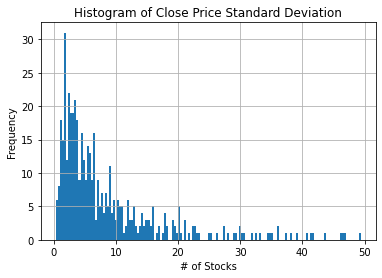

In [481]:
all_model_data[all_model_data['std_close']<50][['std_close']].hist(bins=150)
plt.ylabel('Frequency')
plt.xlabel('# of Stocks')
plt.title('Histogram of Close Price Standard Deviation')
plt.show()

### 6.2 Risk Strategy.

The project recommended the risk strategy based on the standard deviation of the closing price. However, this is not the ideal way to calculate. In a future version, it would make sense to the correct (stock beta, relative to the market, or standard deviation of the % change). Nonetheless:

Less than 5 = conservative; 5-10 = Moderate; Over 10 = Aggressive

In [482]:
conditions = [
    all_model_data['std_close'] < 2.5,
    all_model_data['std_close'] < 8,
    all_model_data['std_close'] >= 8
    ]

values = ['conservative', 'moderate', 'aggressive']


all_model_data['strategy'] = np.select(conditions, values)
all_model_data.head()

,ticker,prediction,todays_close,perc_change,std_close,Symbol,Name,Sector,strategy
0,MMM,176.563061,176.039993,0.002971,8.867188,MMM,3M,Industrials,aggressive
1,AOS,61.550820,61.169998,0.006226,2.950015,AOS,A. O. Smith,Industrials,moderate
2,ABT,117.497713,115.529999,0.017032,5.520341,ABT,Abbott Laboratories,Health Care,moderate
3,ABBV,108.908515,108.730003,0.001642,3.831070,ABBV,AbbVie,Health Care,moderate
4,ABMD,323.126413,313.869995,0.029491,27.236205,ABMD,Abiomed,Health Care,aggressive


In [489]:
columns_to_display = ['Name', 'ticker','perc_change', 'todays_close', 'prediction']

all_model_data[(all_model_data['strategy']=='aggressive') & (all_model_data['perc_change']>0)][columns_to_display].sort_values('perc_change', ascending =False).head(n=10)

,Name,ticker,perc_change,todays_close,prediction
166,Enphase Energy,ENPH,0.068252,145.029999,154.928642
162,Edwards Lifesciences,EW,0.053651,106.370003,112.076862
336,Nvidia,NVDA,0.052834,197.320007,207.745169
184,Facebook,FB,0.051421,326.230011,343.005033
248,IPG Photonics,IPGP,0.051385,153.190002,161.061708
486,Wynn Resorts,WYNN,0.050541,83.559998,87.783219
308,Moderna,MRNA,0.045242,325.839996,340.581592
415,Synopsys,SNPS,0.042798,289.250000,301.629324
140,DexCom,DXCM,0.042224,526.429993,548.657825
53,Autodesk,ADSK,0.041473,272.929993,284.249196


## 7. Future Analysis

1. Add earnings, earnings surprise, P/E, and fundamental variables. 
2. Run using an autoregressive linear model (ie: errors(t) = f(errors(t-i) i: 1-6; ARCH / GARCH)
3. Add documentation on all the other Supervised ML models attempted.